# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/9e/3f/247e0017d52eeef37c170d71357eb3a12a2c06718d2e184c9929b6f3d9ed/shap-0.43.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.9 MB/s eta 0:00:00ta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=21b0cd677ce801d750504a04801200cd141f4a6044234ed390a2d956cb4c924a
  Stored in directory: /home/marchesini_id/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.6 MB/

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Matplotlib is building the font cache; this may take a moment.
2023-10-13 19:09:38.933182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 19:09:43.198708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 19:09:43.201184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:09:48.777776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [3]:
ds_train = pd.read_csv("/home/marchesini_id/buckets/b1/datasets/competencia_02.csv.gz")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [4]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [5]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.089593826,
    'feature_fraction': 0.702677631,
    'verbose': 1,
    'max_bin': 31,
    'min_data_in_leaf': 1406,
    'num_leaves': 373
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


[LightGBM] [Info] Number of positive: 37770, number of negative: 4525040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.003373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5241
[LightGBM] [Info] Number of data points in the train set: 4562810, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008278 -> initscore=-4.785867
[LightGBM] [Info] Start training from score -4.785867


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [6]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


Features  Importances
0                           foto_mes         1102
126                 Master_fechaalta          674
156   ctrx_mcuenta_corriente_slope_6          649
148                   Visa_fechaalta          640
112              Master_Fvencimiento          630
..                               ...          ...
121          Master_madelantodolares            0
13                 ccuenta_corriente            0
14       mcuenta_corriente_adicional            0
164  ctrx_cliente_antiguedad_slope_6            0
2                        cliente_vip            0

[204 rows x 2 columns]

Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [7]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [8]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.3490774076503336


1426      7   
mcuentas_saldo               421356.270000  0.133805
ctarjeta_visa_transacciones      22.000000  0.110879
mtarjeta_visa_consumo         48518.580000  0.097286
Visa_msaldopesos              49125.040000  0.095797
cseguro_vivienda                  1.000000  0.073306
...                                    ...       ...
mcaja_ahorro                    397.650000 -0.316542
avg_6_mrentabilidad_annual     5294.964286 -0.356002
mpayroll                          0.000000 -0.512927
cpayroll_trx                      0.000000 -0.641869
foto_mes                     202105.000000 -1.352470

[204 rows x 2 columns]

En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [9]:
shap_bajas.mean().abs().sort_values(ascending=False)


foto_mes                                 0.618686
ctrx_quarter                             0.468499
ctrx_cdescubierto_preacordado_slope_6    0.352950
mcaja_ahorro                             0.342729
mpayroll                                 0.311649
                                           ...   
ctrx_cliente_antiguedad_slope_6          0.000000
cpayroll2_trx                            0.000000
Visa_madelantodolares                    0.000000
cliente_vip                              0.000000
mpayroll2                                0.000000
Length: 204, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

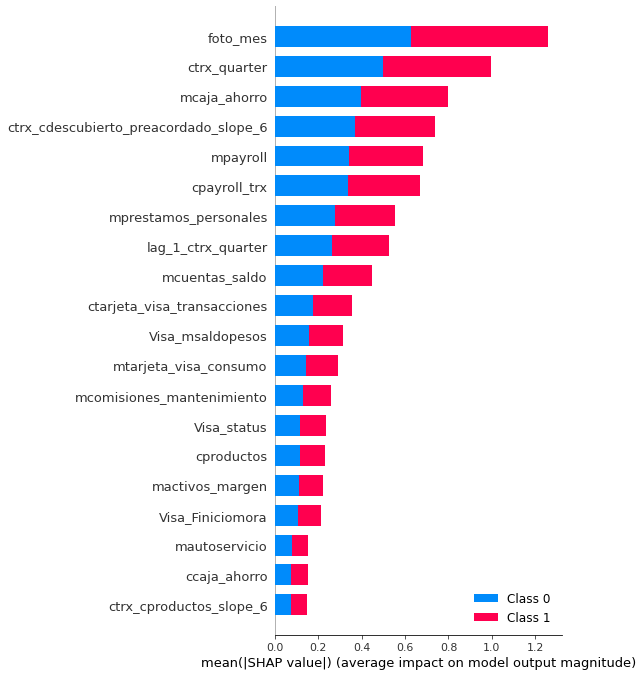

In [10]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

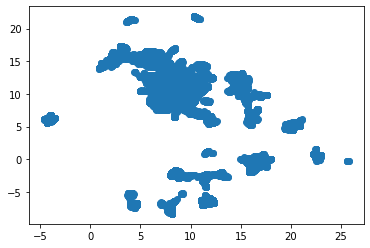

In [11]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([3426., 4090., 3639., 2851., 2421., 2032., 1738., 1567., 1389.,
        1335., 1128., 1050.,  887.,  854.,  722.,  696.,  608.,  639.,
         637.,  547.,  563.,  567.,  542.,  538.,  555.,  504.,  601.,
         633.,  668.,  343.]),
 array([6.50129754e-04, 3.39512352e-02, 6.72523406e-02, 1.00553446e-01,
        1.33854551e-01, 1.67155657e-01, 2.00456762e-01, 2.33757868e-01,
        2.67058973e-01, 3.00360079e-01, 3.33661184e-01, 3.66962290e-01,
        4.00263395e-01, 4.33564500e-01, 4.66865606e-01, 5.00166711e-01,
        5.33467817e-01, 5.66768922e-01, 6.00070028e-01, 6.33371133e-01,
        6.66672238e-01, 6.99973344e-01, 7.33274449e-01, 7.66575555e-01,
        7.99876660e-01, 8.33177766e-01, 8.66478871e-01, 8.99779976e-01,
        9.33081082e-01, 9.66382187e-01, 9.99683293e-01]),
 <BarContainer object of 30 artists>)

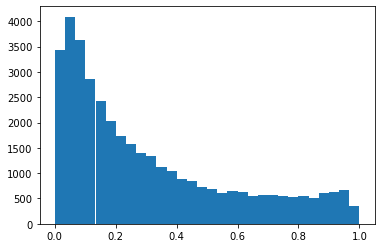

In [12]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

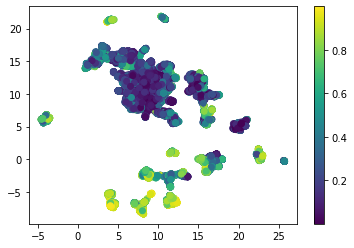

In [13]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


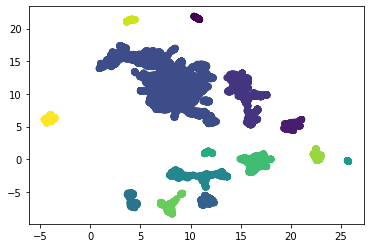

In [16]:

hdb = DBSCAN(eps=0.85) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_)
plt.show()

In [17]:
clusters_list = np.unique(y.labels_)
clusters_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [46]:
bajas_prob = shap_bajas.copy()
bajas_prob["prob"] = p_bajas
bajas_prob

foto_mes  active_quarter  cliente_vip  internet  cliente_edad  \
0     -0.513272       -0.004698          0.0 -0.049537     -0.084057   
1     -0.506159        0.001896          0.0 -0.049157     -0.073939   
2     -0.290529       -0.004625          0.0  0.068949     -0.059044   
3     -0.318746       -0.006272          0.0  0.110344      0.055100   
4     -0.225219        0.011431          0.0 -0.025354     -0.088049   
...         ...             ...          ...       ...           ...   
37765 -0.919102        0.000284          0.0 -0.032236      0.021876   
37766 -0.379561       -0.001421          0.0  0.008864     -0.033116   
37767 -0.433957       -0.001412          0.0  0.034558     -0.033868   
37768 -0.289444        0.069928          0.0 -0.039980      0.034560   
37769 -0.279891        0.061723          0.0 -0.027096      0.032727   

       cliente_antiguedad  mrentabilidad  mrentabilidad_annual  mcomisiones  \
0               -0.016933       0.010360             -0.019953    -0.006339   
1               -0.017632       0.017292             -0.028163    -0.006118   
2                0.019684      -0.085656              0.007754     0.001404   
3               -0.016026      -0.026017             -0.015052     0.007932   
4               -0.002571      -0.007197             -0.020758     0.005154   
...                   ...            ...                   ...          ...   
37765            0.020349       0.032070             -0.061595     0.004655   
37766           -0.060259      -0.049772             -0.034874    -0.019075   
37767           -0.027258      -0.018466             -0.047974    -0.006565   
37768            0.005188       0.001650             -0.123709     0.009758   
37769            0.005455       0.026038             -0.140319    -0.002605   

       mactivos_margen  ...  avg_6_mprestamos_personales  avg_6_ctarjeta_visa  \
0            -0.090880  ...                     0.015075            -0.035663   
1            -0.094421  ...                     0.015584            -0.035918   
2            -0.020960  ...                     0.003638            -0.000356   
3            -0.097171  ...                     0.003256            -0.089147   
4            -0.126981  ...                     0.006795            -0.013792   
...                ...  ...                          ...                  ...   
37765        -0.080186  ...                     0.025767             0.000783   
37766        -0.144043  ...                    -0.013246            -0.000443   
37767         0.051843  ...                    -0.010309             0.001321   
37768        -0.091394  ...                     0.009752             0.002999   
37769        -0.061270  ...                     0.009862             0.003684   

       avg_6_mpayroll  avg_6_cliente_antiguedad  avg_6_Visa_mpagospesos  \
0           -0.034783                 -0.023869                0.017460   
1           -0.038642                 -0.015180                0.010691   
2           -0.114202                  0.016937               -0.044036   
3           -0.147327                 -0.021764                0.043281   
4           -0.038153                 -0.015831               -0.030024   
...               ...                       ...                     ...   
37765       -0.034779                  0.012011                0.003509   
37766       -0.089682                 -0.016051               -0.041067   
37767       -0.094863                 -0.004398               -0.023063   
37768       -0.033890                 -0.002173                0.014788   
37769       -0.038306                 -0.002776                0.006966   

       avg_6_mrentabilidad_annual  avg_6_cproductos  \
0                       -0.051392          0.023365   
1                       -0.051309          0.029040   
2                       -0.012298         -0.063370   
3                       -0.032537         -0.005310   
4                       -0.036922          0

In [54]:
bajas_prob["Cluster"] = y.labels_

media_probabilidad_baja_por_cluster = bajas_prob.groupby('Cluster')['prob'].mean()

for cluster, prob_media in media_probabilidad_baja_por_cluster.items():
    print(f'Cluster {cluster}: Probabilidad Media de Baja = {prob_media}')

Cluster 0: Probabilidad Media de Baja = 0.46634648600395173
Cluster 1: Probabilidad Media de Baja = 0.1333457366299538
Cluster 2: Probabilidad Media de Baja = 0.2631616415027538
Cluster 3: Probabilidad Media de Baja = 0.20234933213787315
Cluster 4: Probabilidad Media de Baja = 0.8526122973210843
Cluster 5: Probabilidad Media de Baja = 0.8905325759440418
Cluster 6: Probabilidad Media de Baja = 0.6012122927248904
Cluster 7: Probabilidad Media de Baja = 0.3115620292348261
Cluster 8: Probabilidad Media de Baja = 0.749238599991046
Cluster 9: Probabilidad Media de Baja = 0.4729144465441121
Cluster 10: Probabilidad Media de Baja = 0.8659434062945806
Cluster 11: Probabilidad Media de Baja = 0.6652204790874319
Cluster 12: Probabilidad Media de Baja = 0.7365184950654392
Cluster 13: Probabilidad Media de Baja = 0.6361154033718419


In [72]:
cantidad_bajas_por_cluster = bajas_prob.groupby('Cluster').size()
print(cantidad_bajas_por_cluster)

Cluster
0       295
1      1302
2      3746
3     24640
4       646
5       847
6      2055
7       121
8       225
9      1479
10      967
11      639
12      225
13      583
dtype: int64


En base a las probabilidades promedio de baja de cada cluster, vamos a analizar en particular los clusters con probabilidad media > 0.30. Es decir, nos vamos a quedar con los clusters 0, 4, 5, 6, 7, 8, 9, 10, 11, 12 y 13

In [38]:
shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False).head(10)

lag_1_cproductos                   0.101866
thomebanking                       0.045665
avg_6_mcuenta_corriente            0.039116
ctrx_mcaja_ahorro_slope_6          0.032537
ccaja_ahorro                       0.022214
avg_6_cproductos                   0.020108
ccajas_consultas                   0.018868
avg_6_cdescubierto_preacordado     0.018136
chomebanking_transacciones         0.017335
lag_1_Visa_mfinanciacion_limite    0.014687
dtype: float64

In [19]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False).head(10)

cpayroll_trx                             0.386365
mpayroll                                 0.213746
ccaja_ahorro                             0.023198
mcomisiones_mantenimiento                0.013757
ctrx_cdescubierto_preacordado_slope_6    0.008939
Visa_Finiciomora                         0.002883
Visa_madelantopesos                      0.000214
mcheques_depositados_rechazados          0.000058
ccheques_depositados_rechazados          0.000048
mpayroll2                                0.000000
dtype: float64

In [20]:
shap_bajas[y.labels_ == 2].mean().sort_values(ascending=False).head(10)

mprestamos_personales                    0.327597
ccaja_ahorro                             0.009815
active_quarter                           0.005910
cprestamos_personales                    0.004687
ctrx_cdescubierto_preacordado_slope_6    0.004346
Visa_mpagado                             0.002872
ctarjeta_visa_debitos_automaticos        0.002004
matm_other                               0.001108
Visa_mconsumospesos                      0.001018
mcaja_ahorro_adicional                   0.000577
dtype: float64

In [21]:
shap_bajas[y.labels_ == 3].mean().sort_values(ascending=False).head(10)

ctrx_cdescubierto_preacordado_slope_6    0.010411
Visa_mpagado                             0.003774
ctarjeta_visa_debitos_automaticos        0.003142
Visa_Finiciomora                         0.001849
matm_other                               0.001327
cforex_buy                               0.001087
catm_trx_other                           0.000438
mcajeros_propios_descuentos              0.000418
ctransferencias_recibidas                0.000348
ctarjeta_master_debitos_automaticos      0.000310
dtype: float64

In [22]:
shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False).head(10)

mprestamos_personales             0.252044
avg_6_cdescubierto_preacordado    0.075971
cdescubierto_preacordado          0.046393
avg_6_mcuenta_corriente           0.042659
lag_1_ctrx_quarter                0.033876
Visa_msaldopesos                  0.031158
ccaja_ahorro                      0.019338
avg_6_mtarjeta_visa_consumo       0.019133
lag_1_mcuenta_corriente           0.015651
thomebanking                      0.014916
dtype: float64

In [23]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False).head(10)

mprestamos_personales             0.112173
avg_6_cdescubierto_preacordado    0.105315
avg_6_mcuenta_corriente           0.052694
ccaja_ahorro                      0.035600
lag_1_mcuenta_corriente           0.034307
Visa_mconsumospesos               0.018278
cdescubierto_preacordado          0.017499
thomebanking                      0.016751
Visa_mpagado                      0.007983
chomebanking_transacciones        0.006277
dtype: float64

In [24]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False).head(10)

ctrx_mcuenta_corriente_slope_6       0.096866
avg_6_mcuenta_corriente              0.038728
avg_6_cdescubierto_preacordado       0.037338
lag_1_mcuenta_corriente              0.037066
thomebanking                         0.018764
chomebanking_transacciones           0.009719
Visa_mpagado                         0.008136
ctarjeta_visa_debitos_automaticos    0.007372
Visa_mconsumospesos                  0.005726
cmobile_app_trx                      0.004309
dtype: float64

In [25]:
shap_bajas[y.labels_ == 7].mean().sort_values(ascending=False)

lag_1_ctrx_quarter            0.751187
avg_6_mcuenta_corriente       0.021224
chomebanking_transacciones    0.013148
active_quarter                0.011637
thomebanking                  0.009782
                                ...   
cpayroll_trx                 -0.348065
mcaja_ahorro                 -0.401846
ctrx_quarter                 -0.797457
foto_mes                     -0.822841
Visa_Finiciomora             -1.431360
Length: 204, dtype: float64


Shap importance for cluster 0:


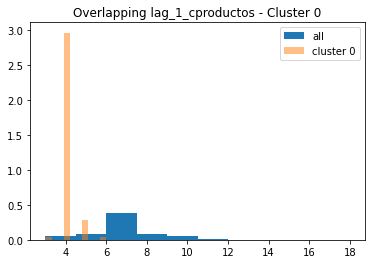

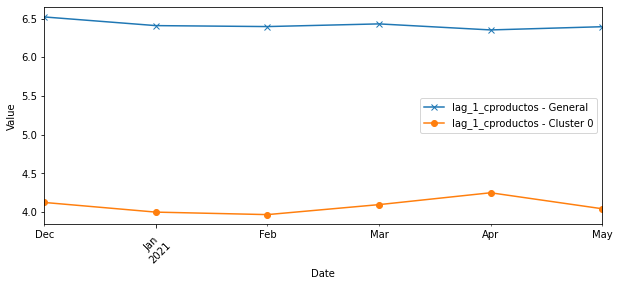

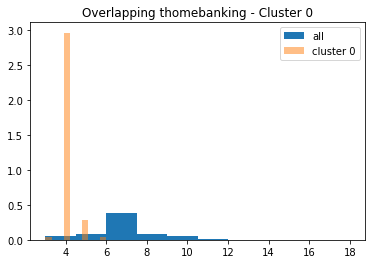

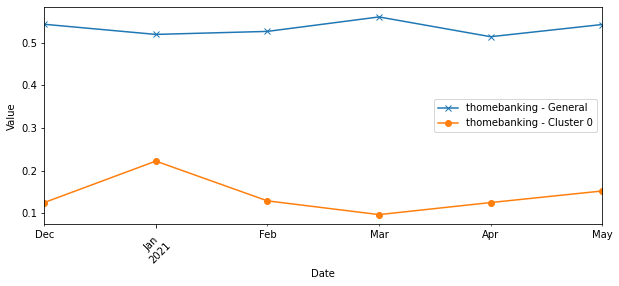

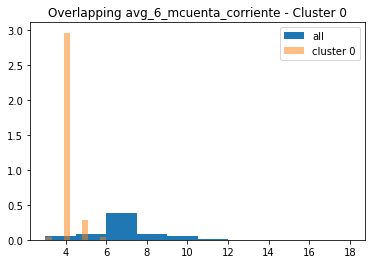

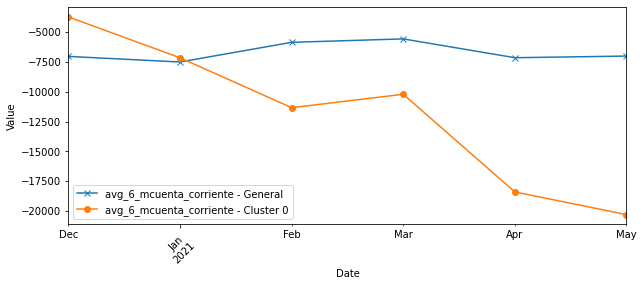

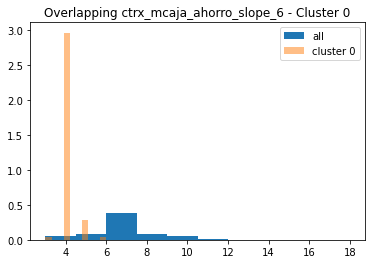

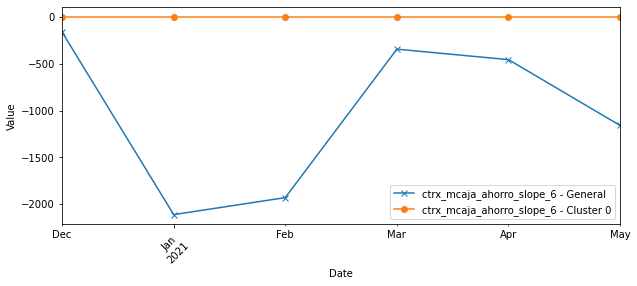

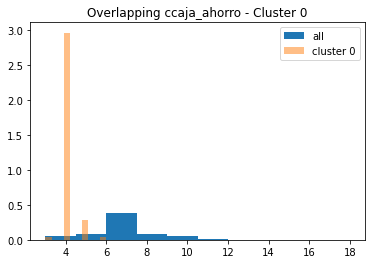

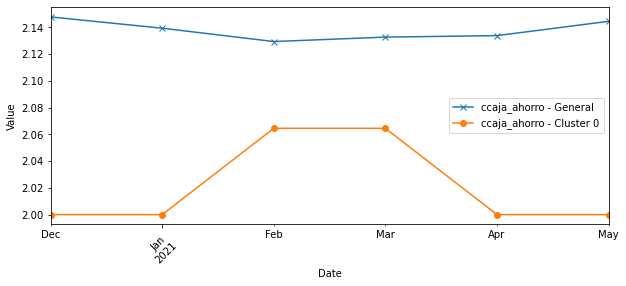

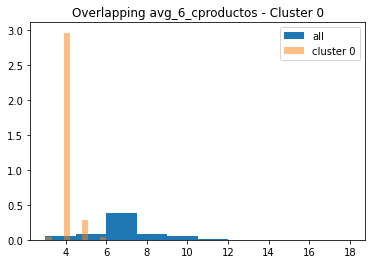

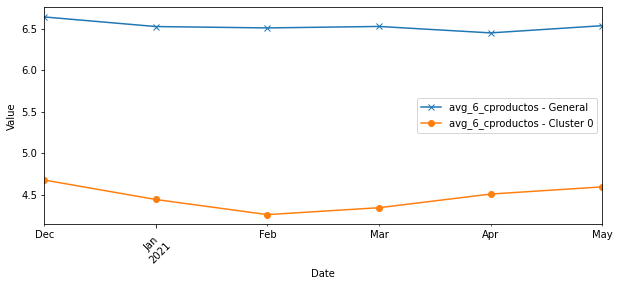

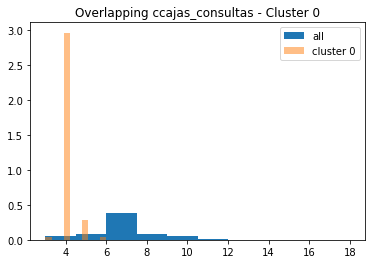

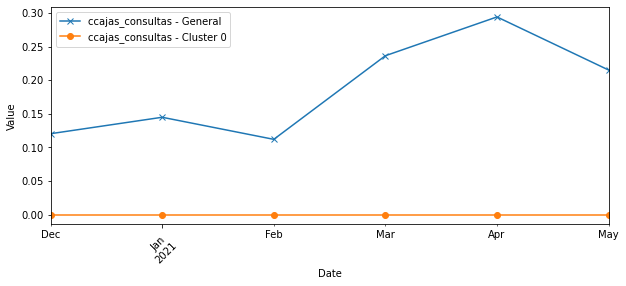

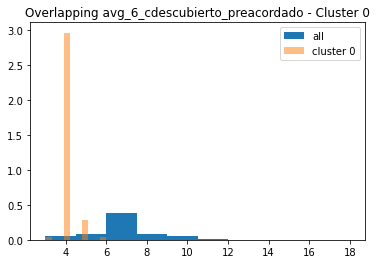

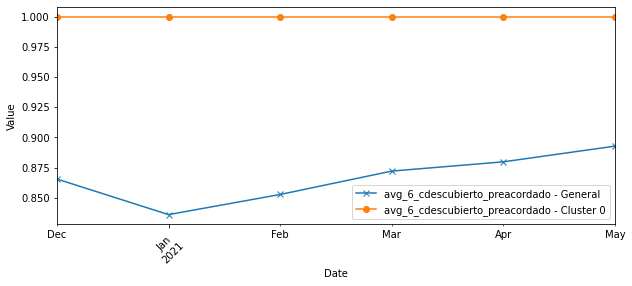

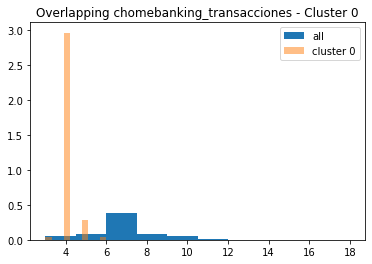

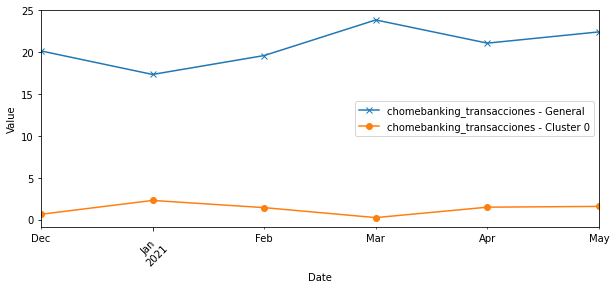

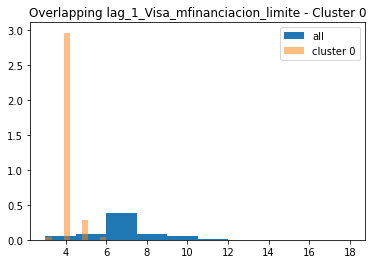

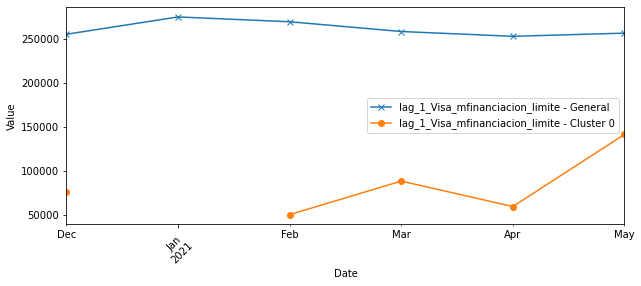

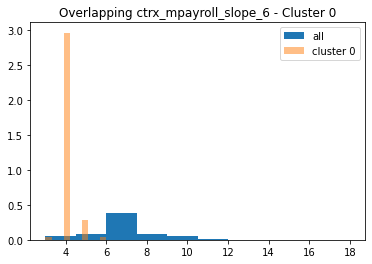

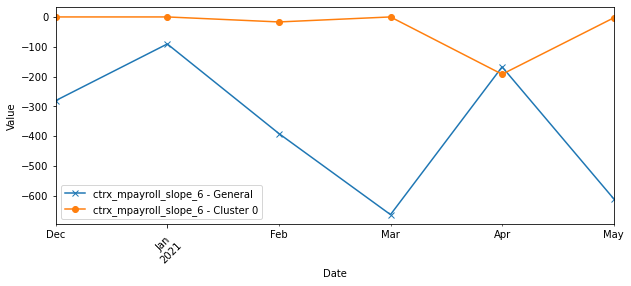

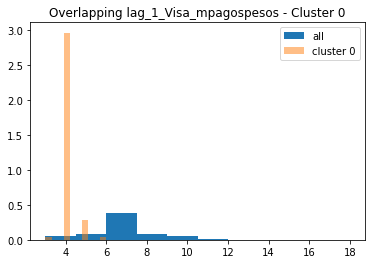

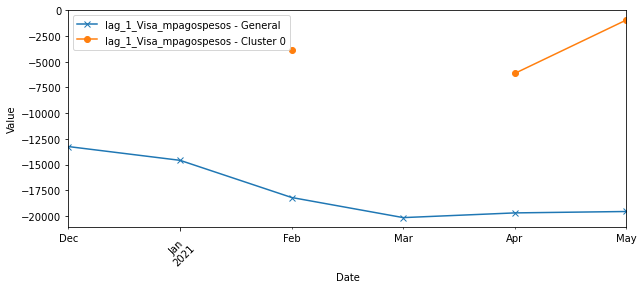

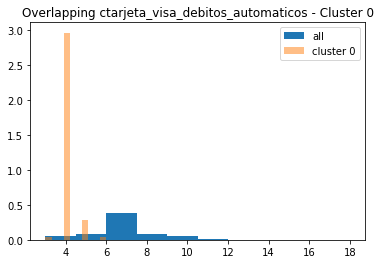

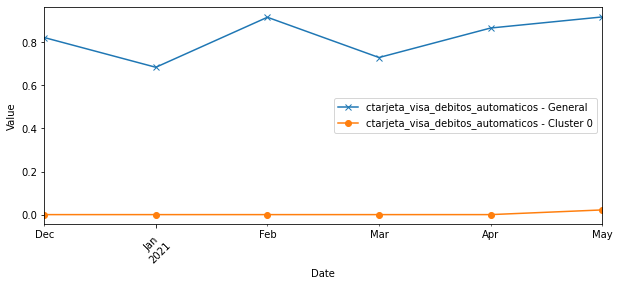

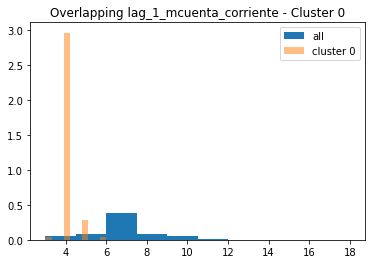

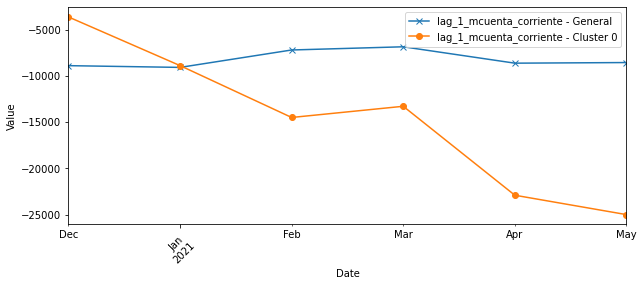


Shap importance for cluster 1:


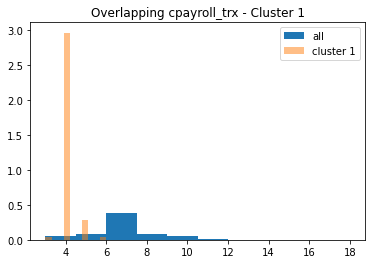

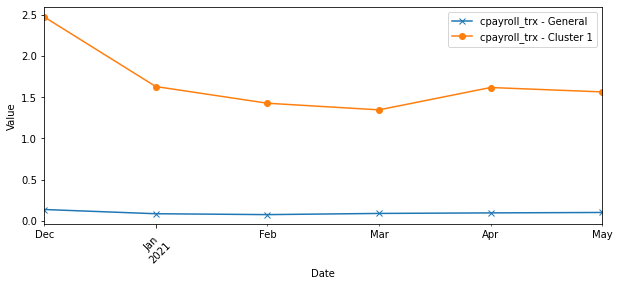

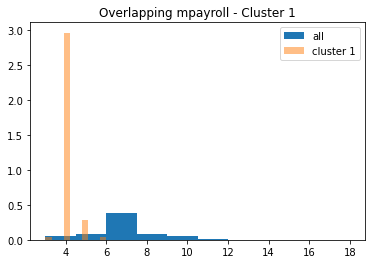

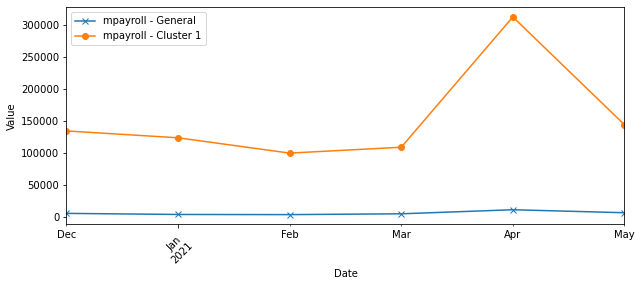

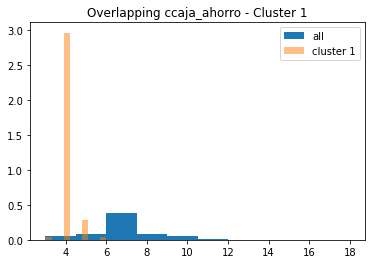

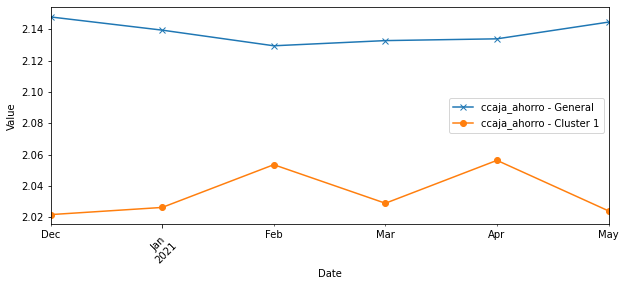

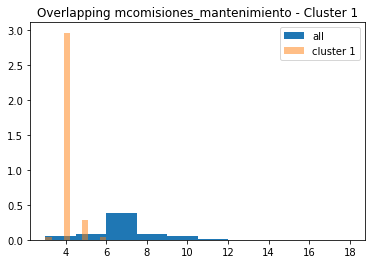

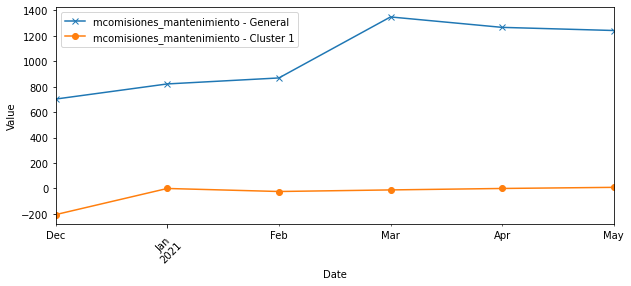

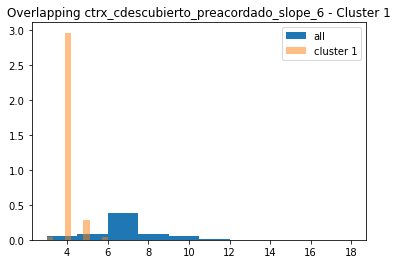

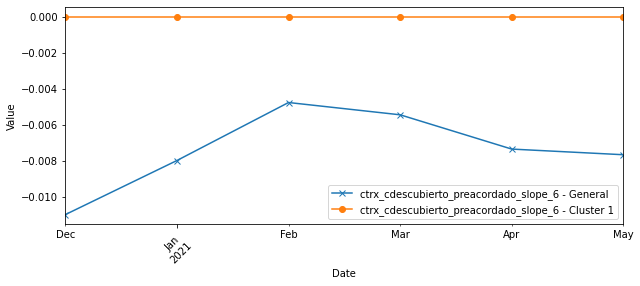

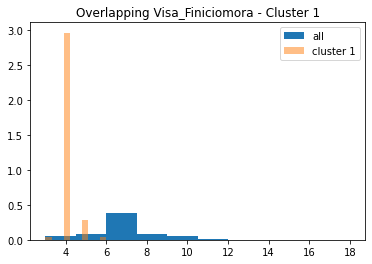

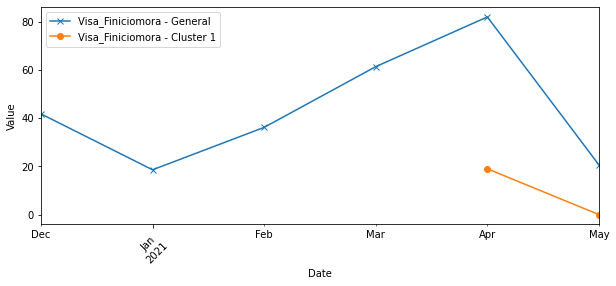

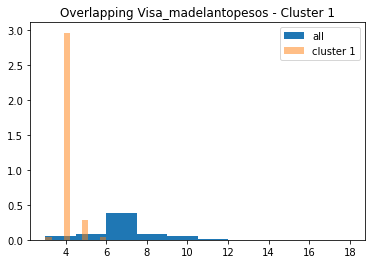

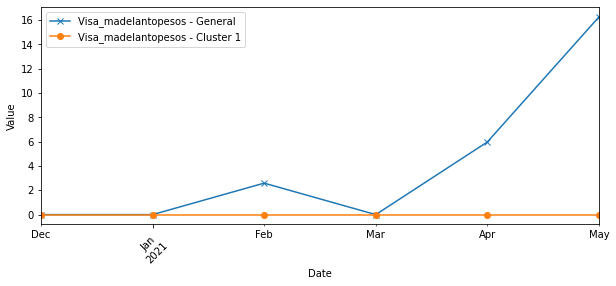

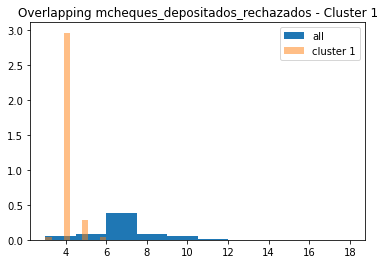

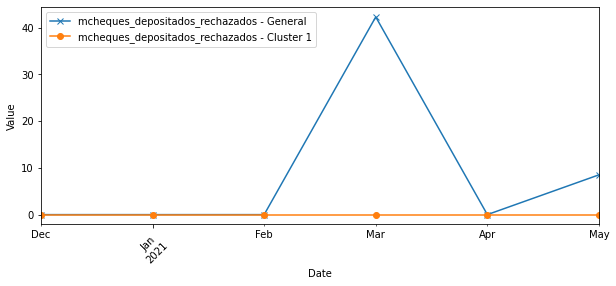

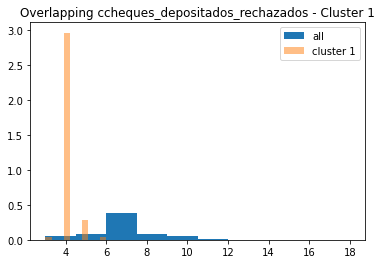

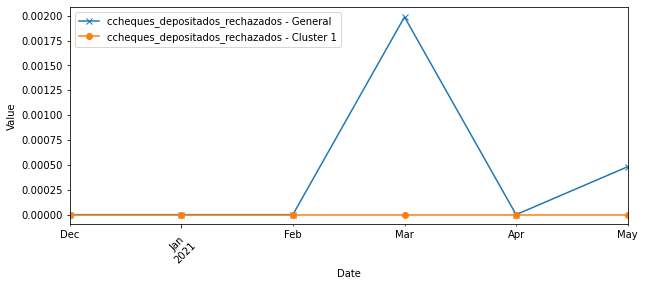

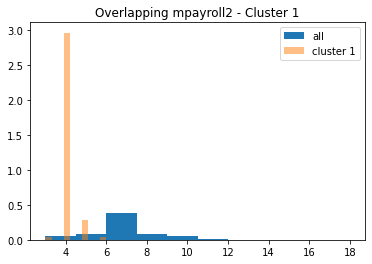

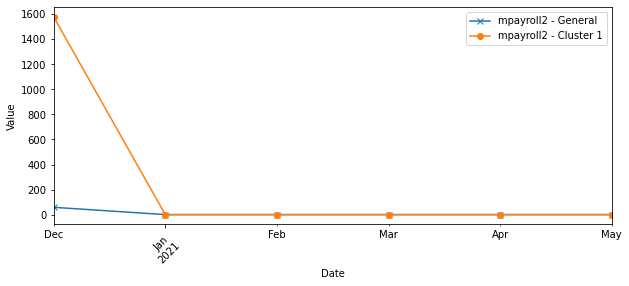

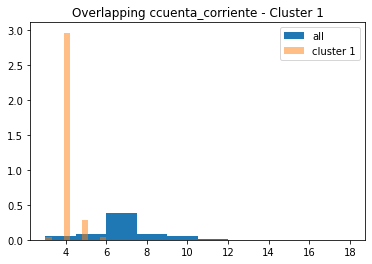

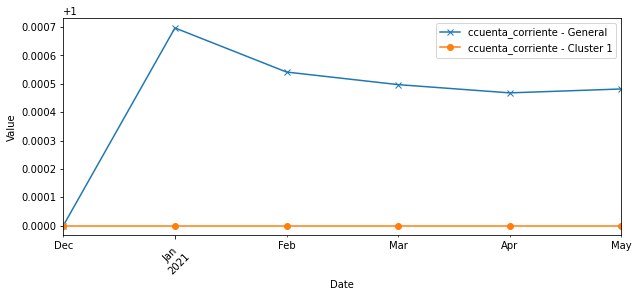

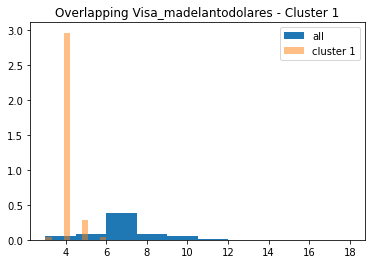

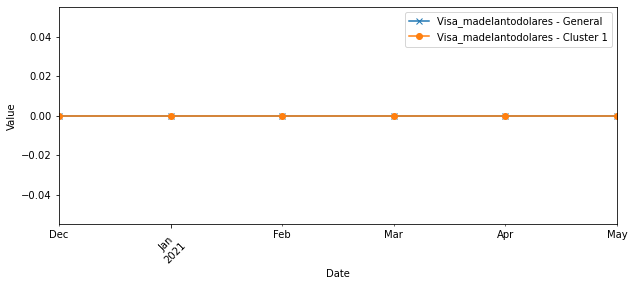

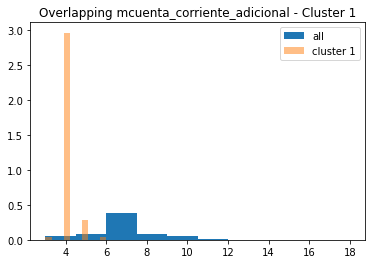

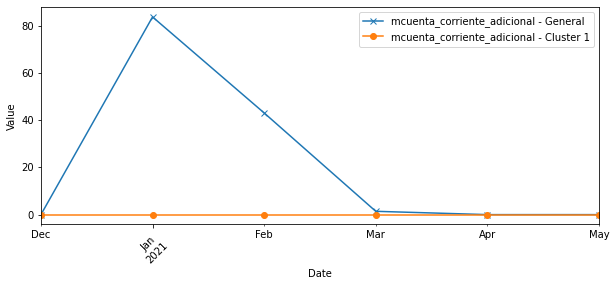

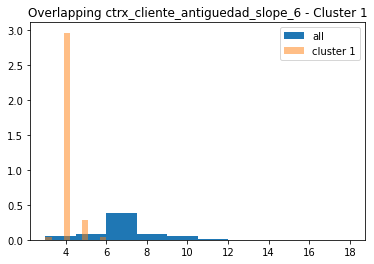

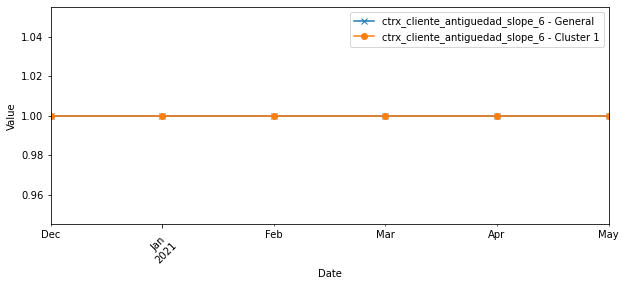

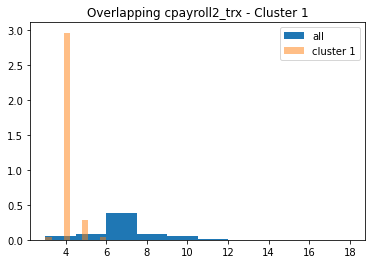

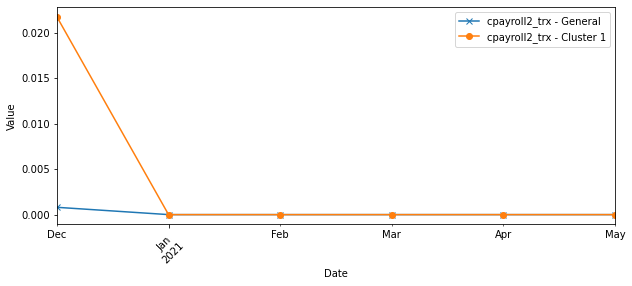


Shap importance for cluster 2:


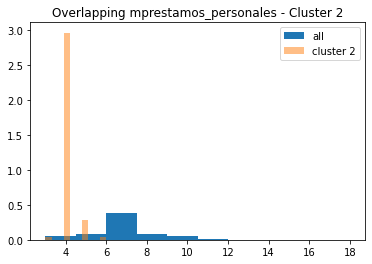

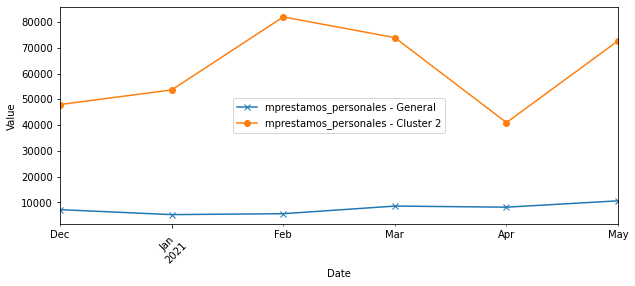

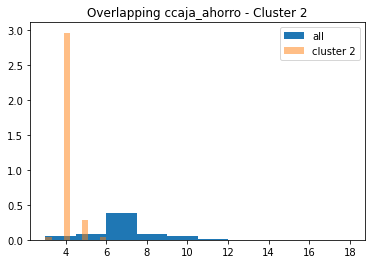

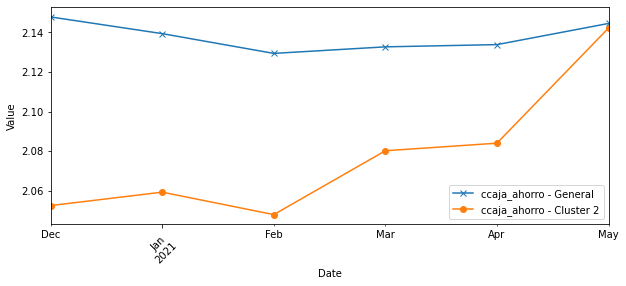

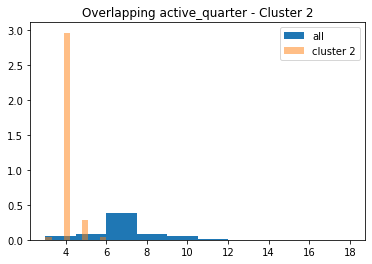

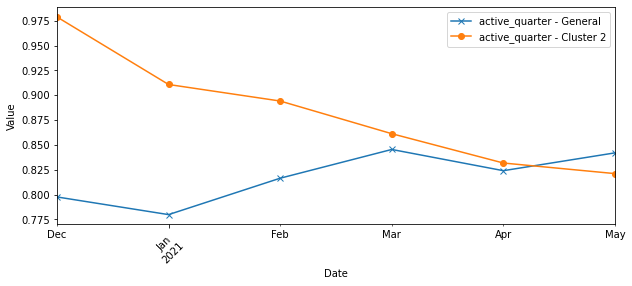

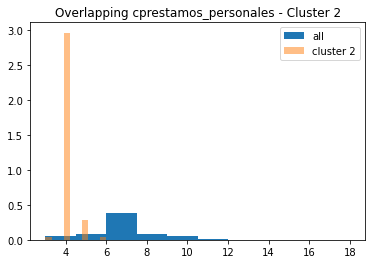

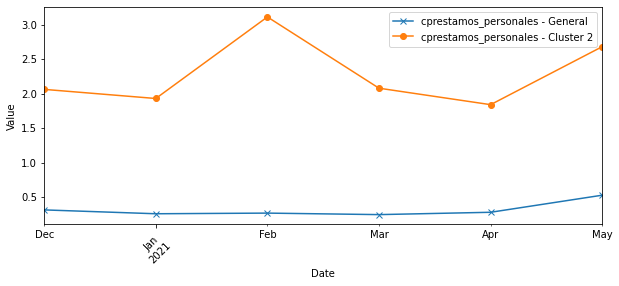

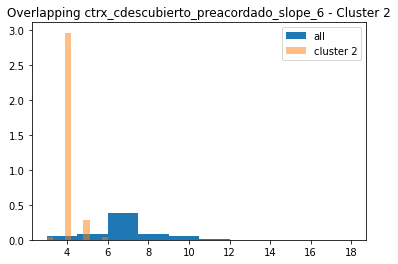

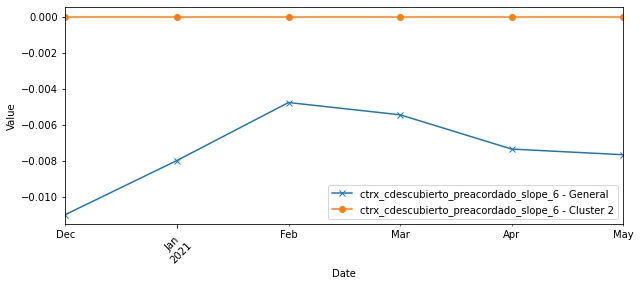

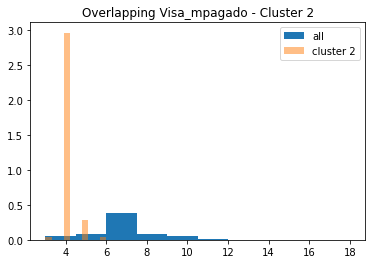

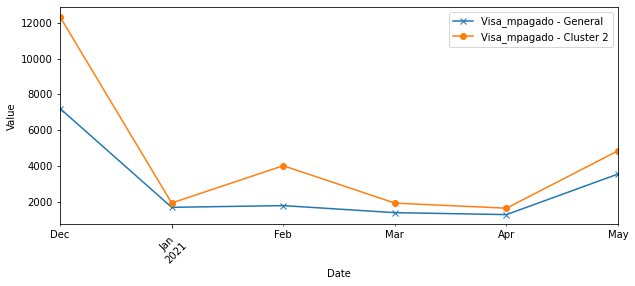

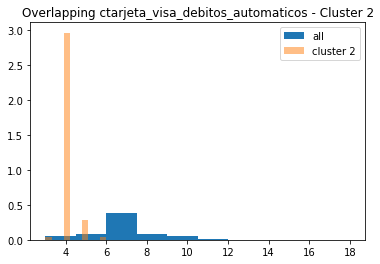

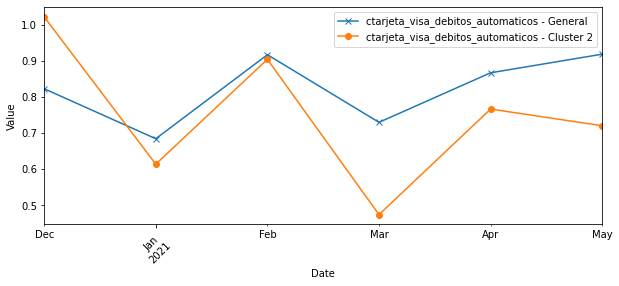

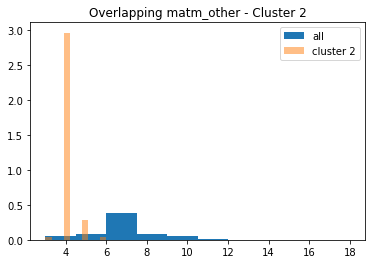

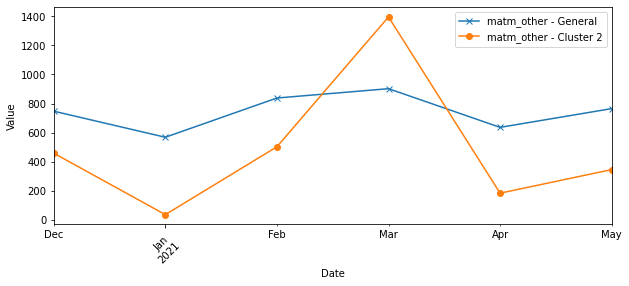

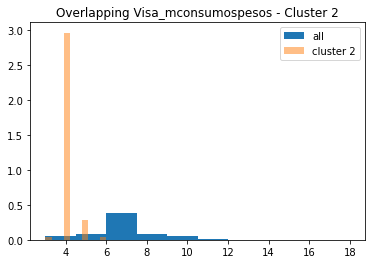

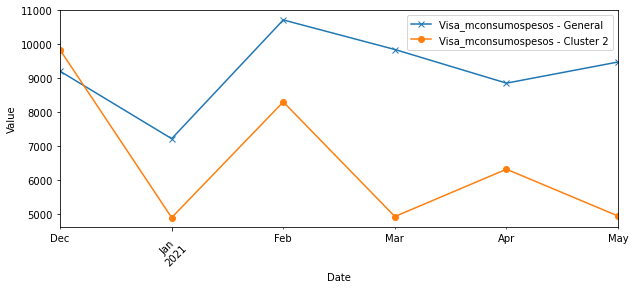

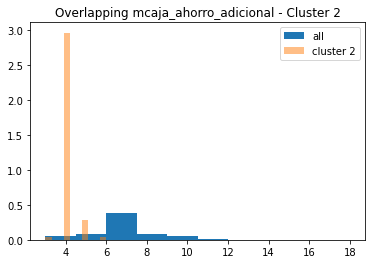

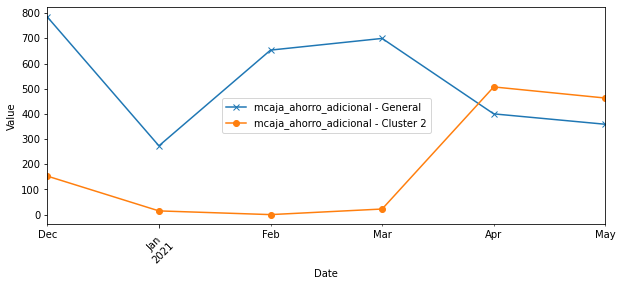

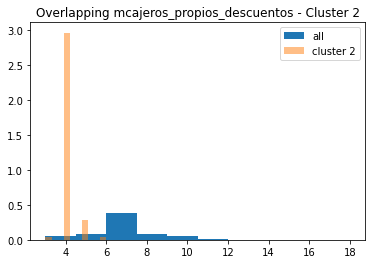

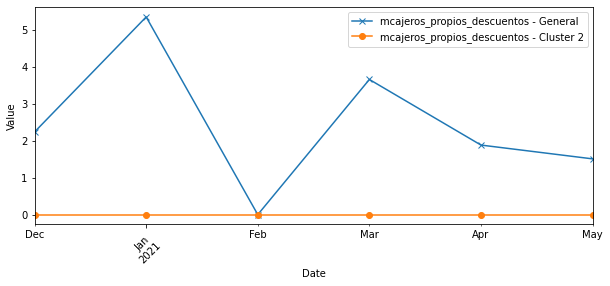

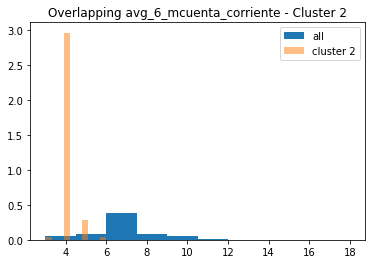

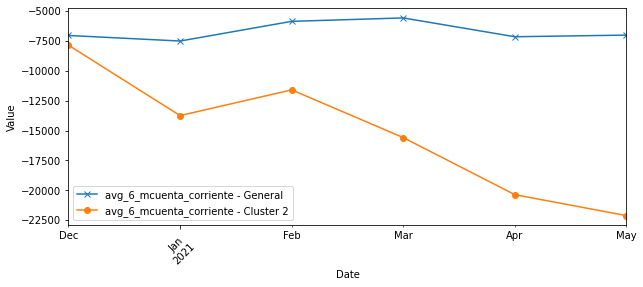

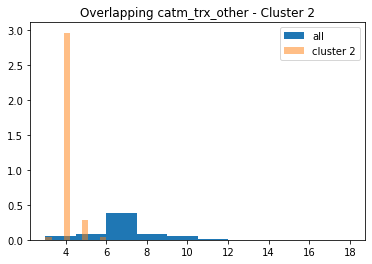

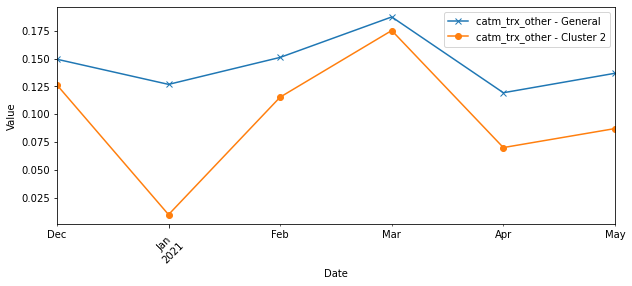

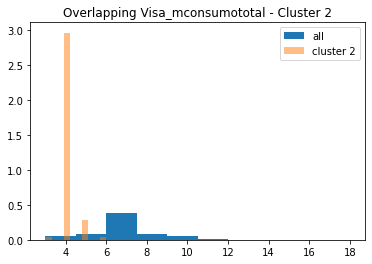

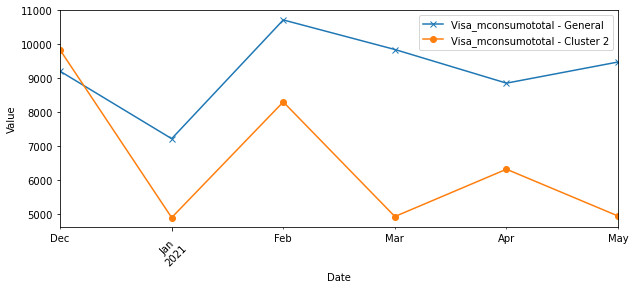

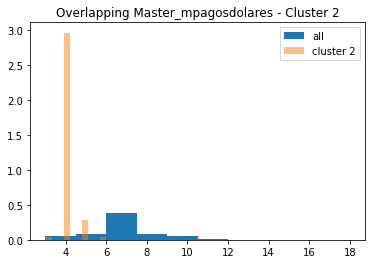

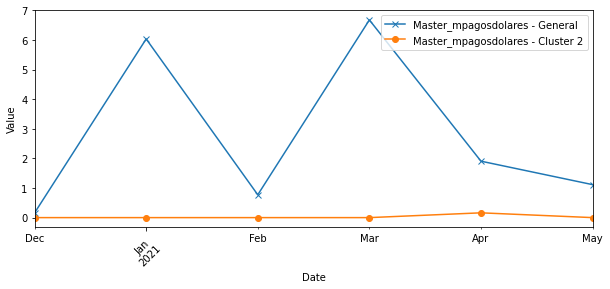


Shap importance for cluster 3:


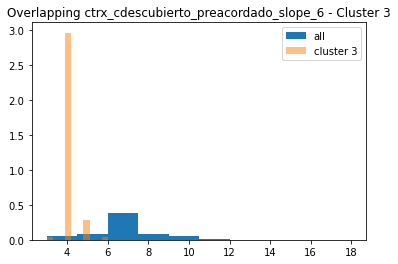

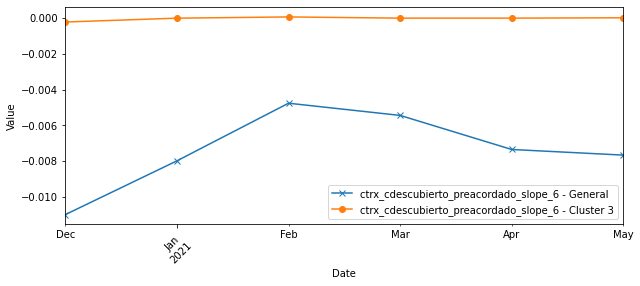

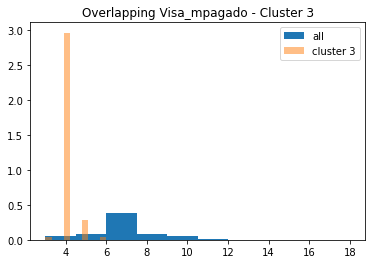

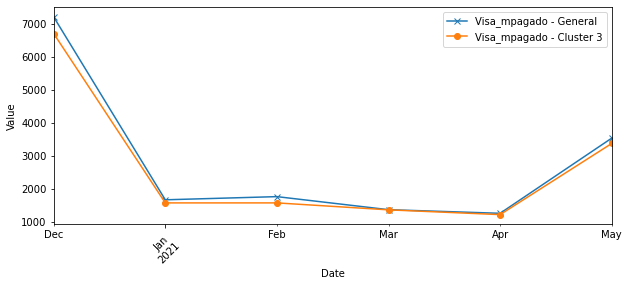

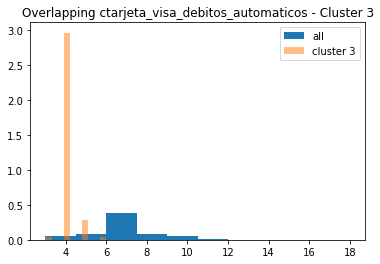

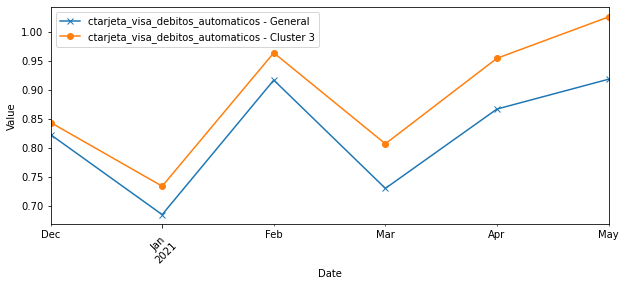

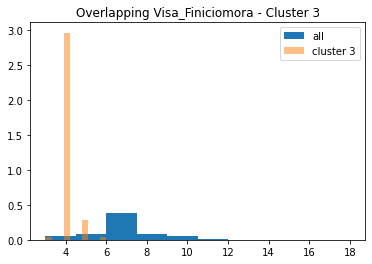

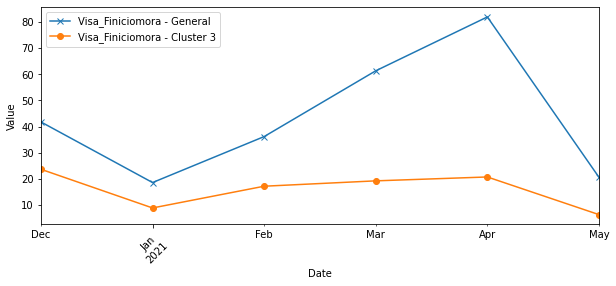

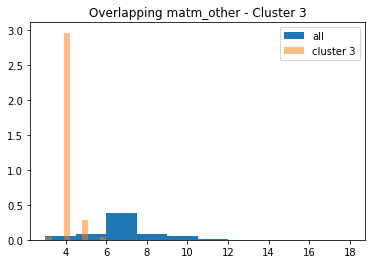

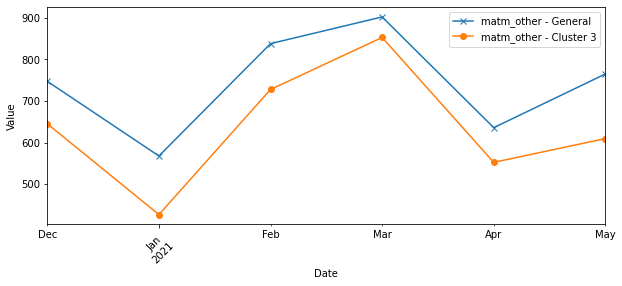

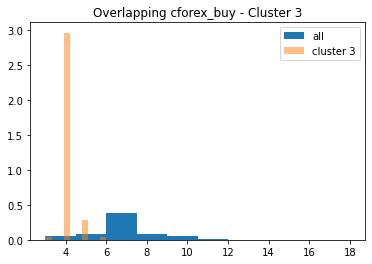

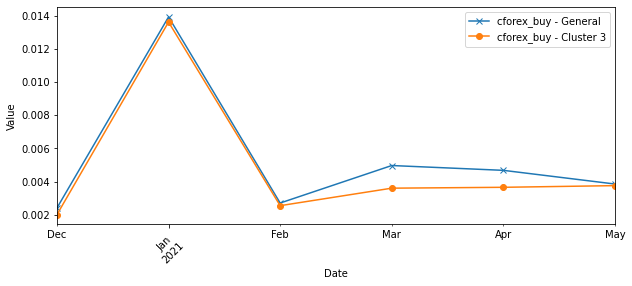

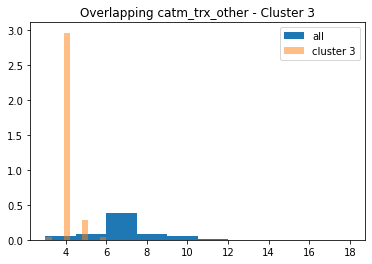

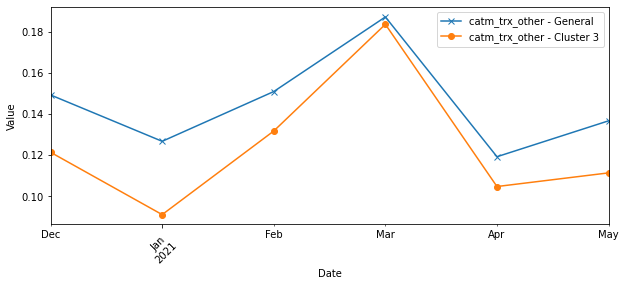

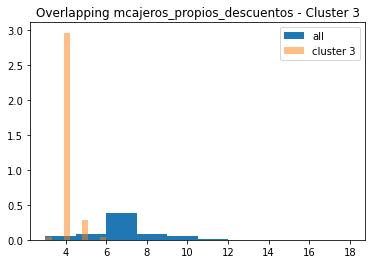

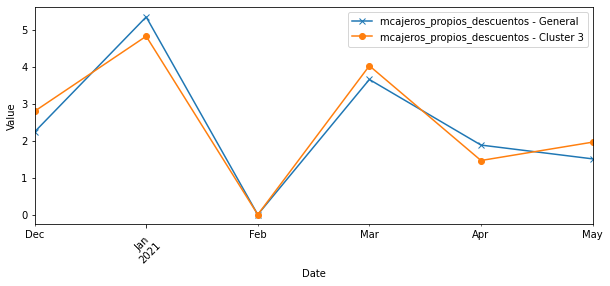

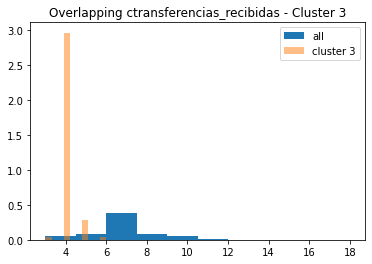

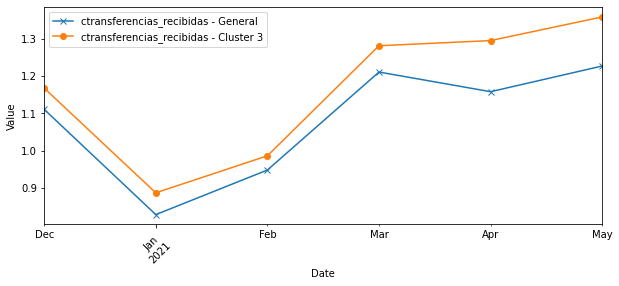

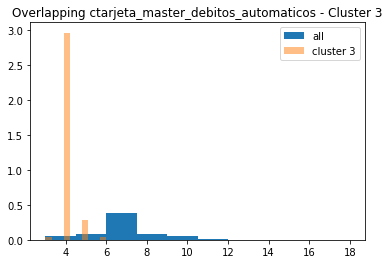

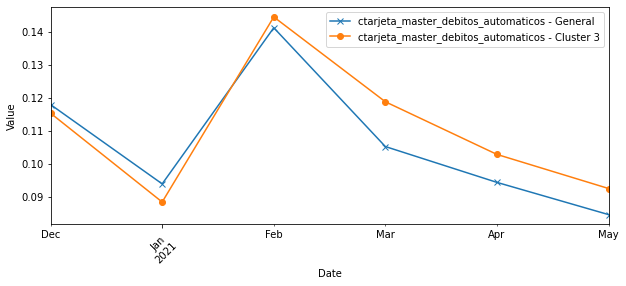

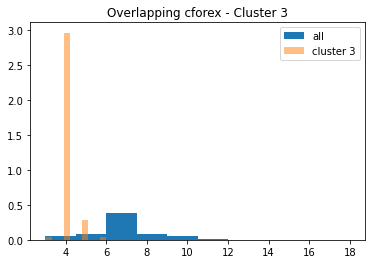

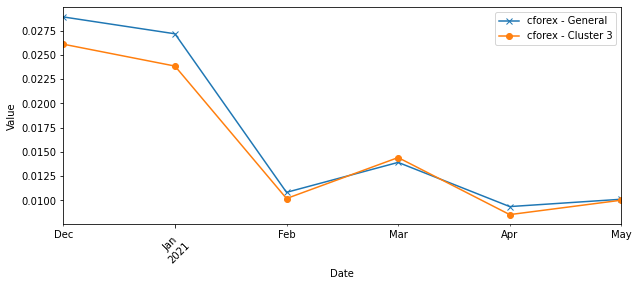

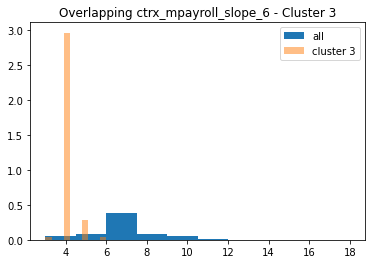

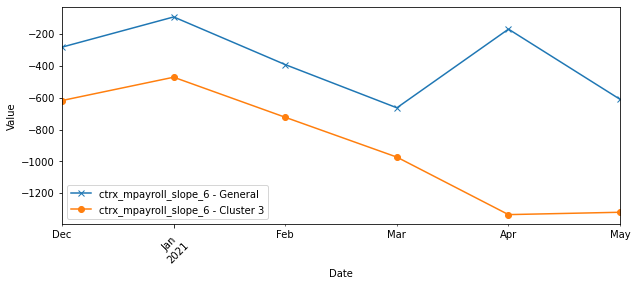

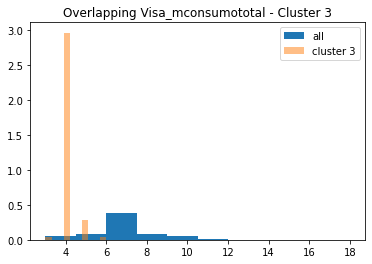

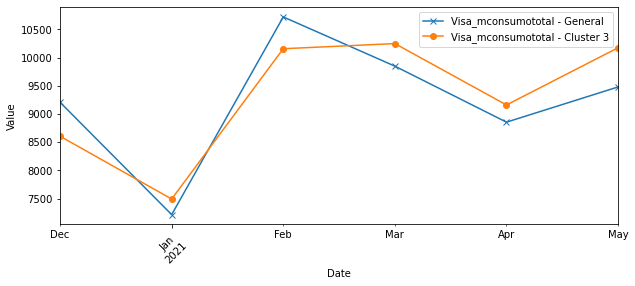

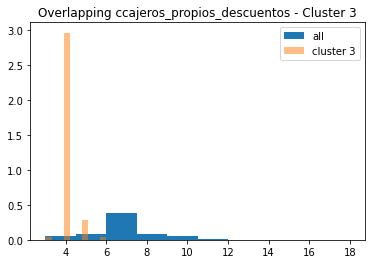

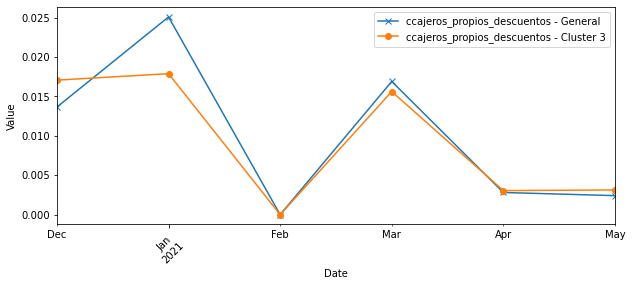

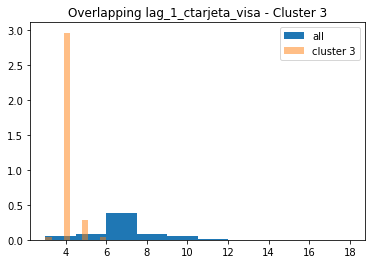

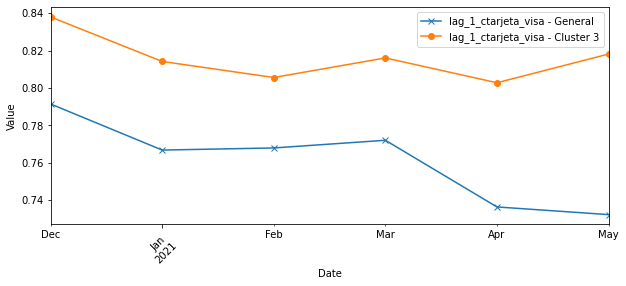


Shap importance for cluster 4:


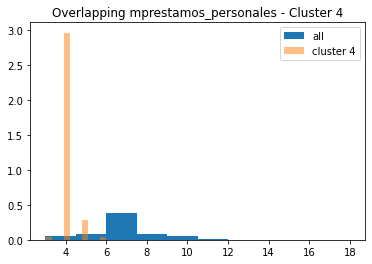

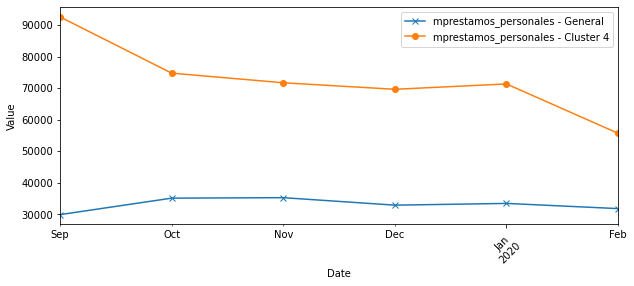

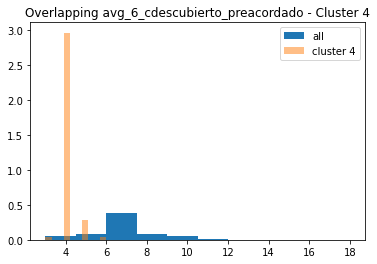

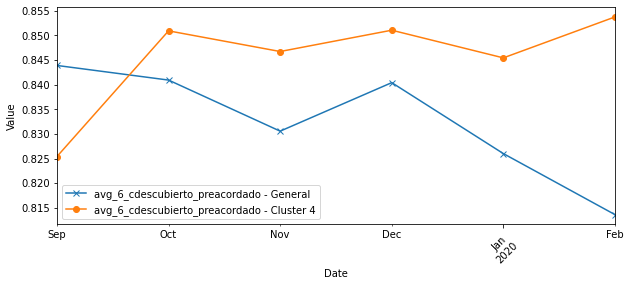

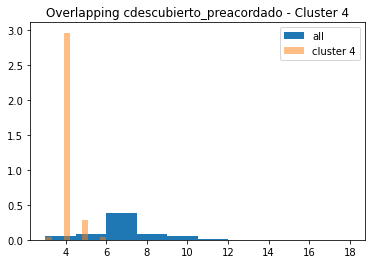

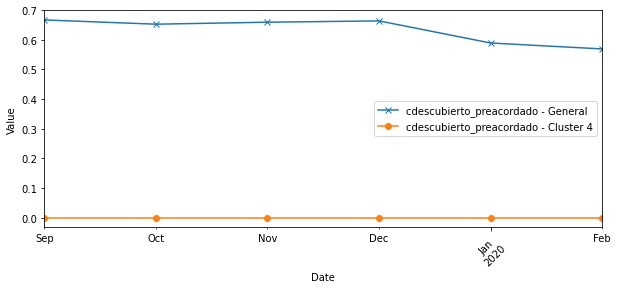

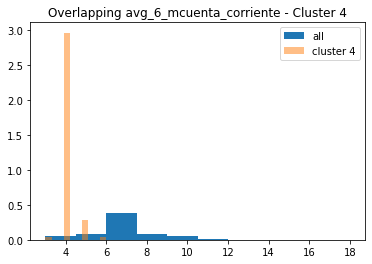

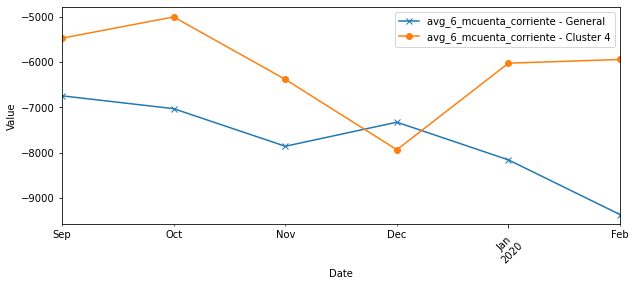

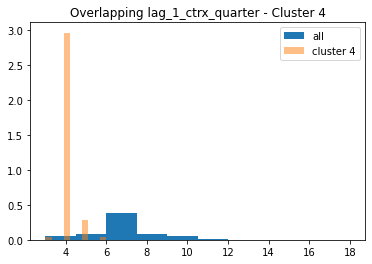

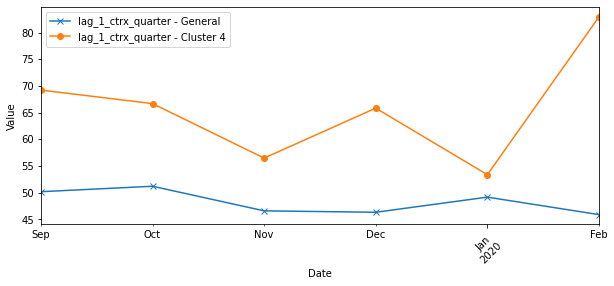

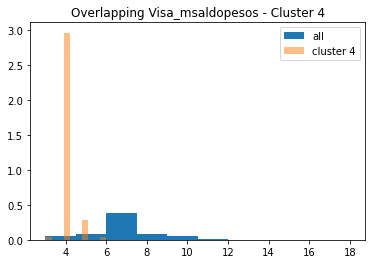

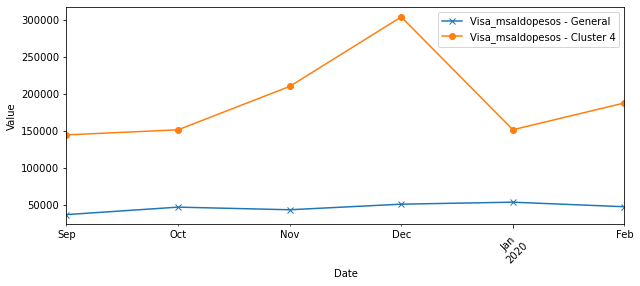

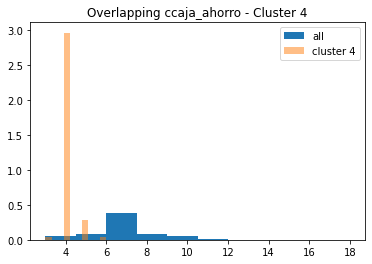

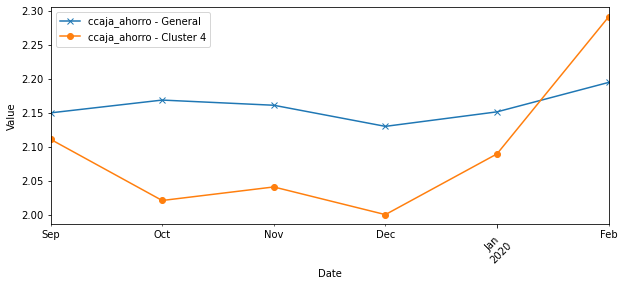

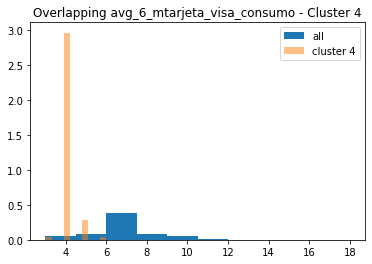

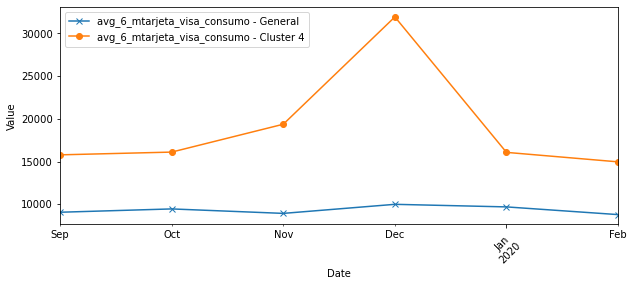

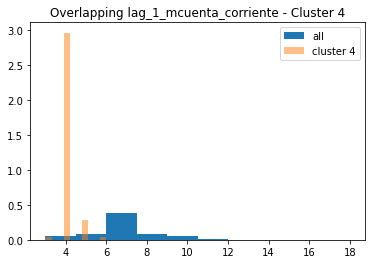

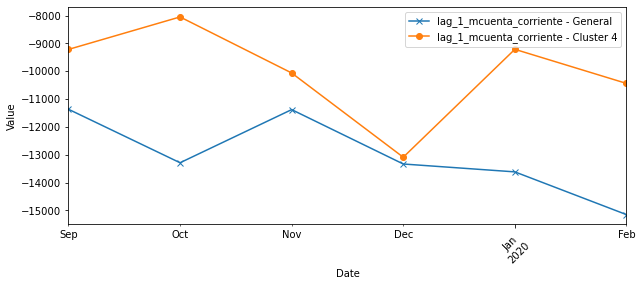

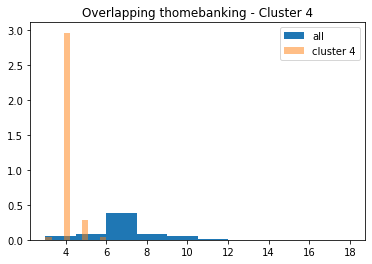

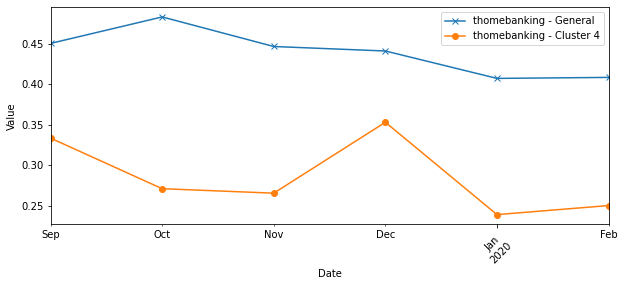

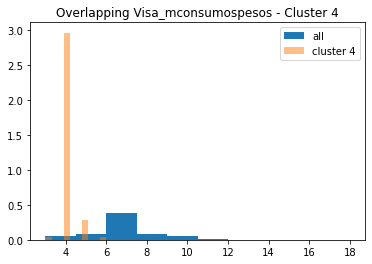

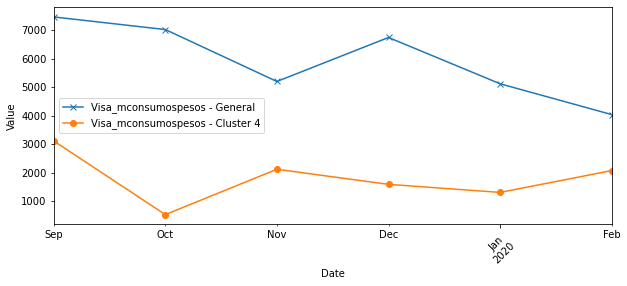

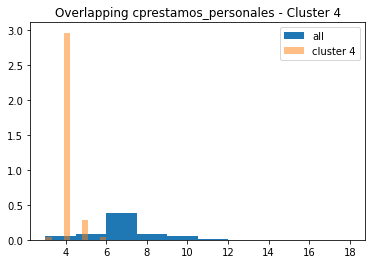

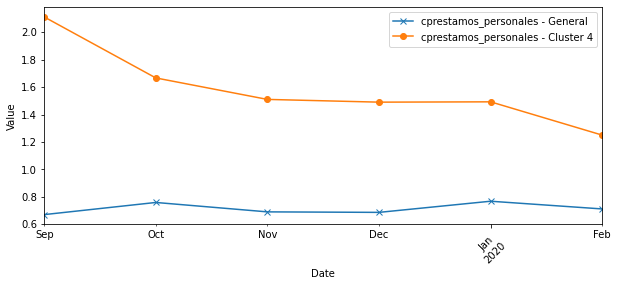

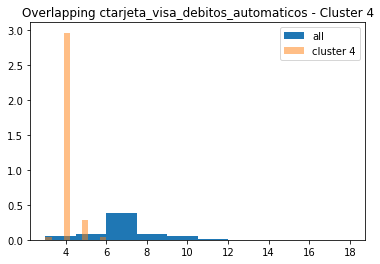

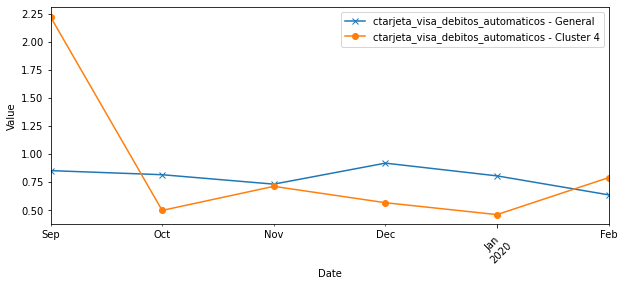

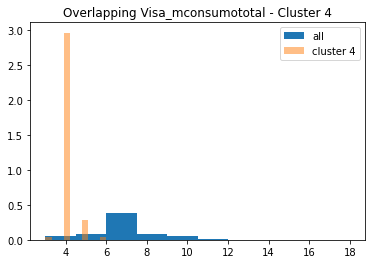

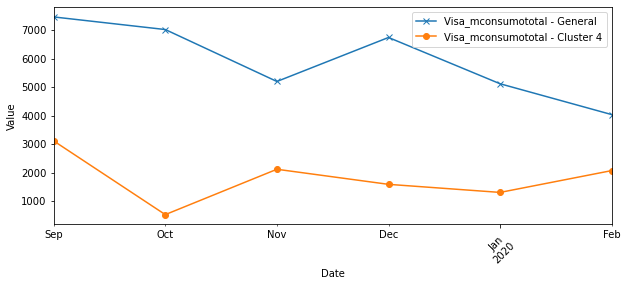

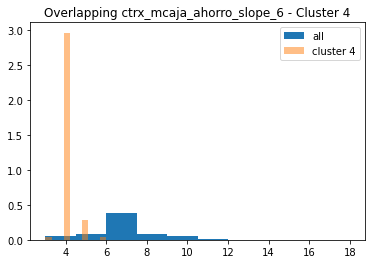

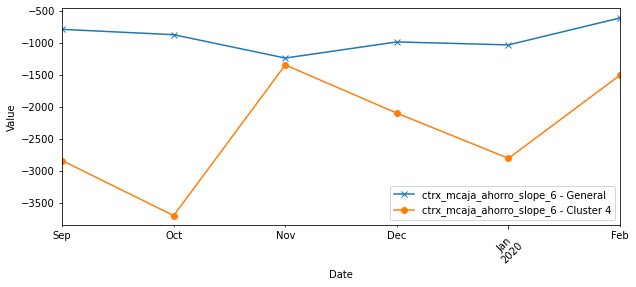


Shap importance for cluster 5:


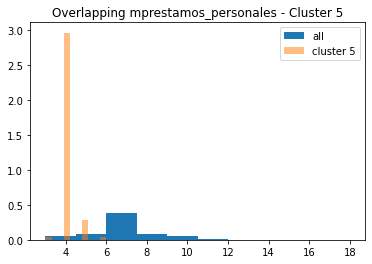

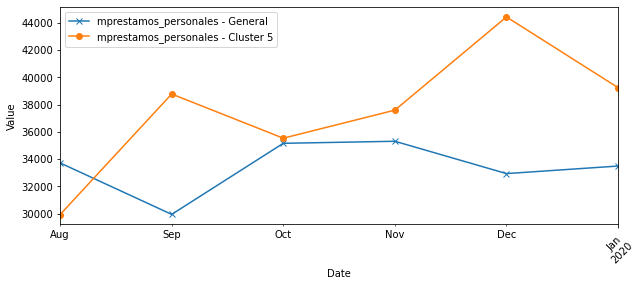

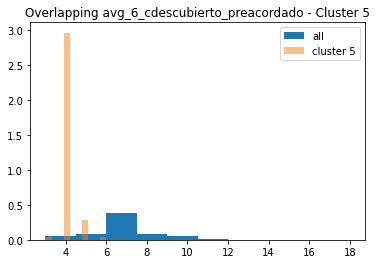

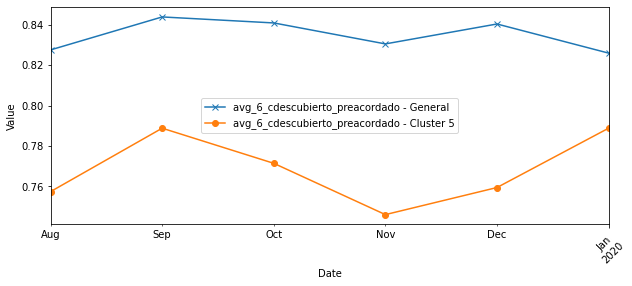

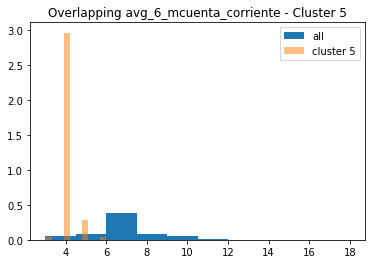

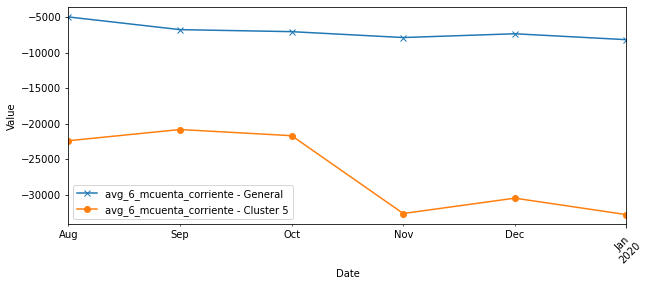

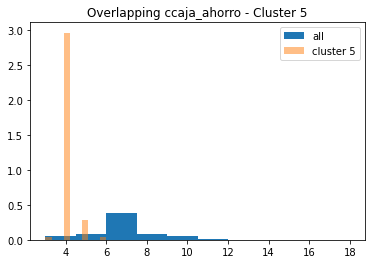

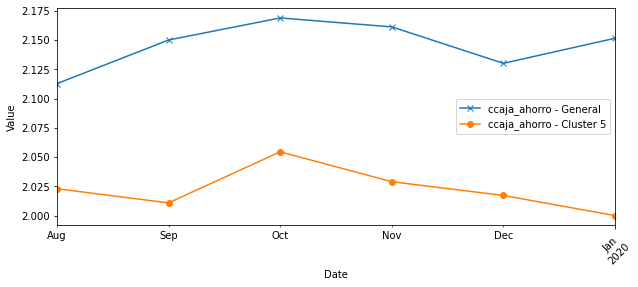

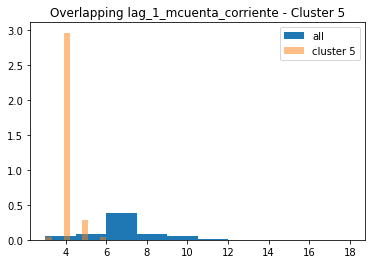

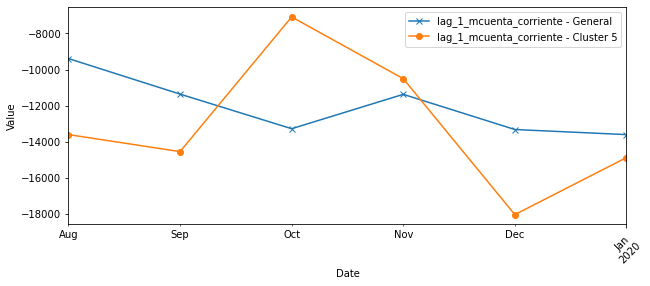

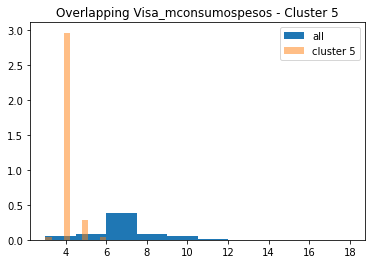

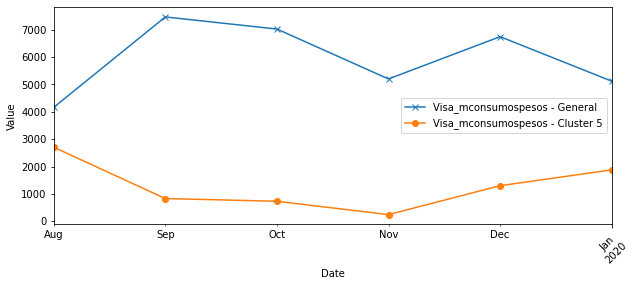

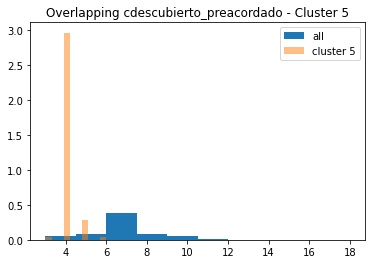

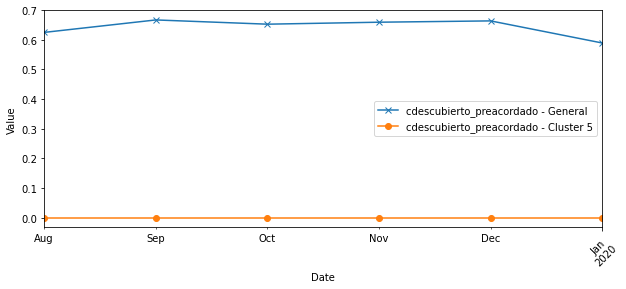

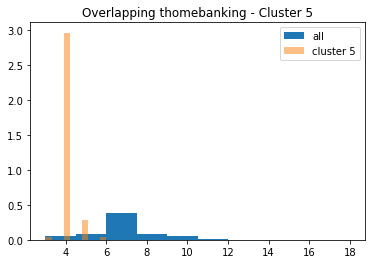

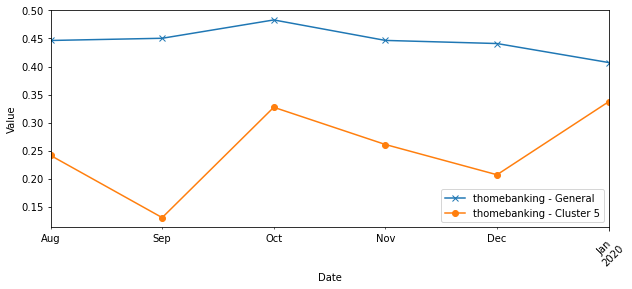

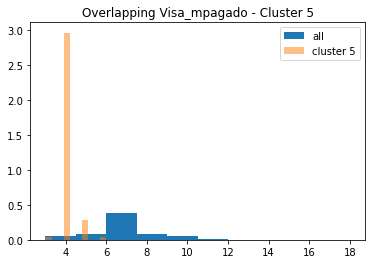

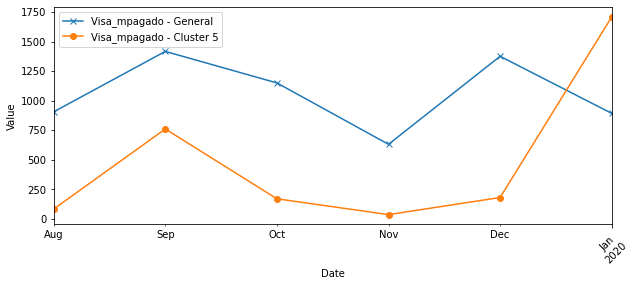

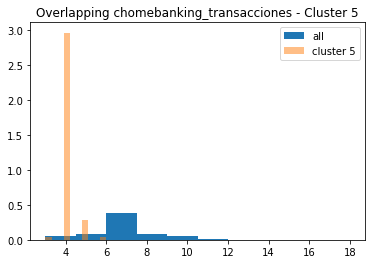

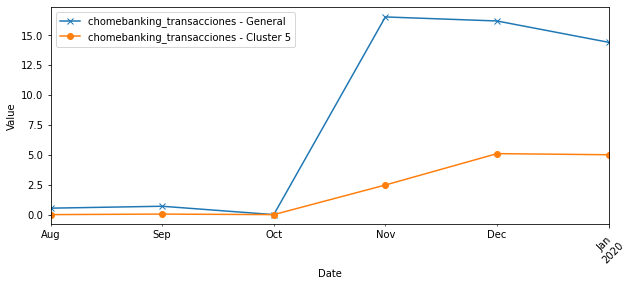

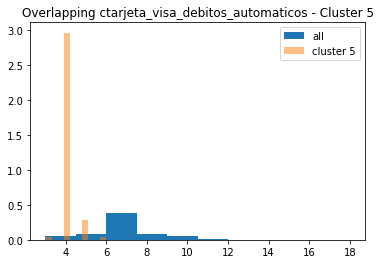

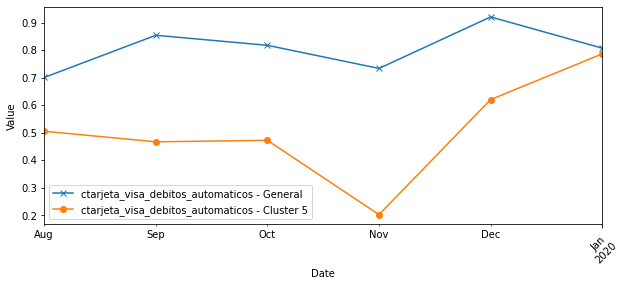

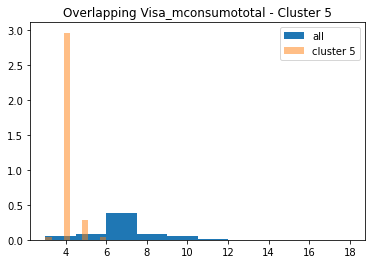

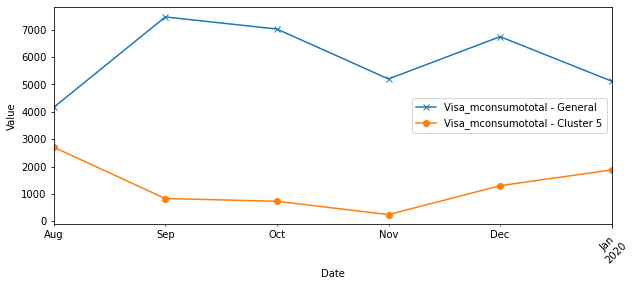

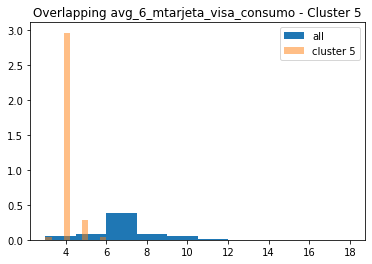

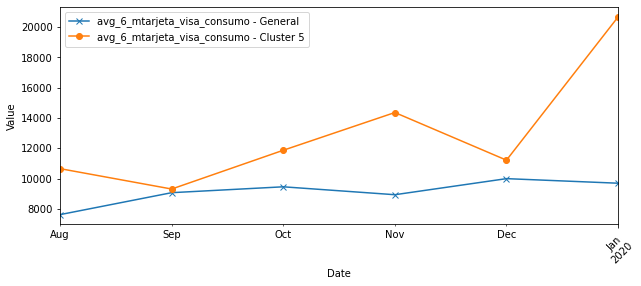

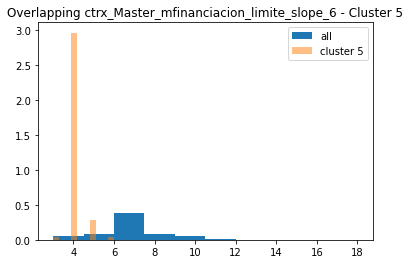

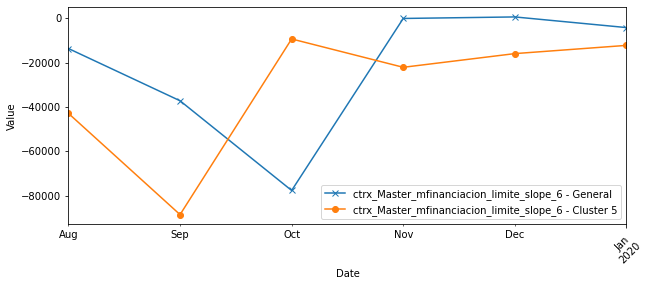

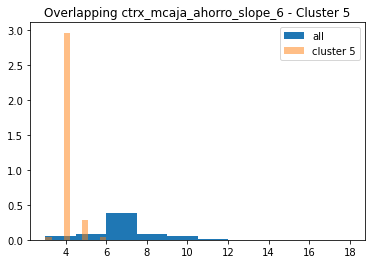

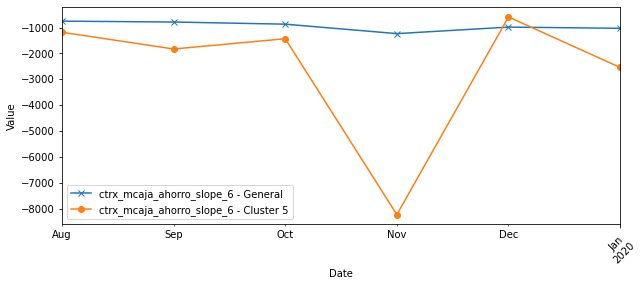


Shap importance for cluster 6:


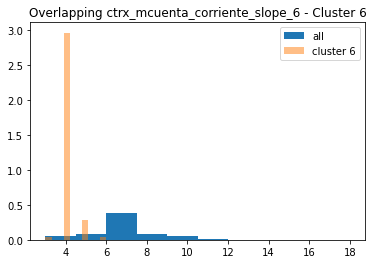

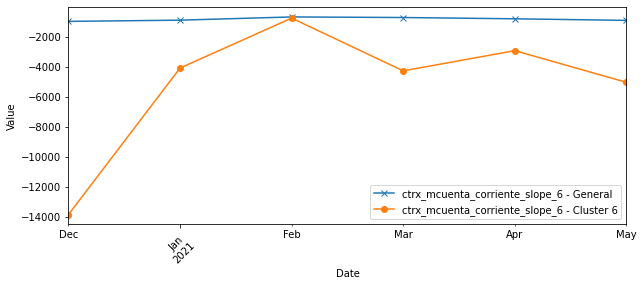

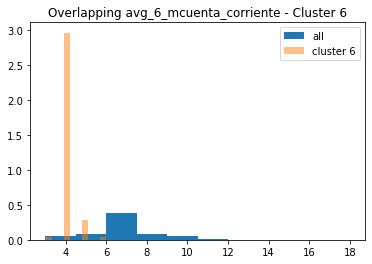

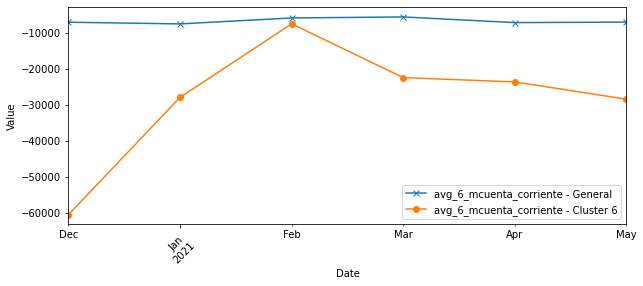

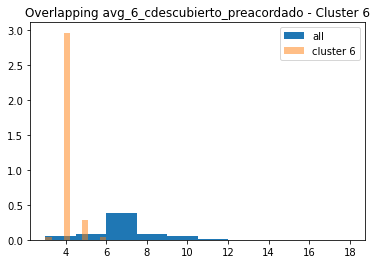

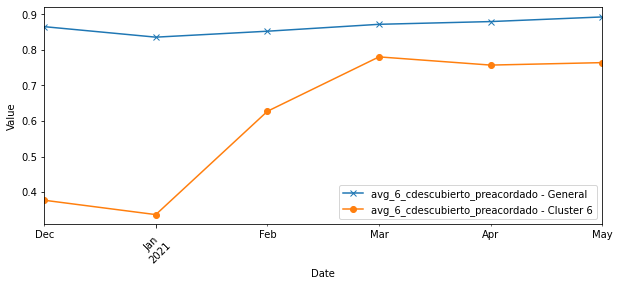

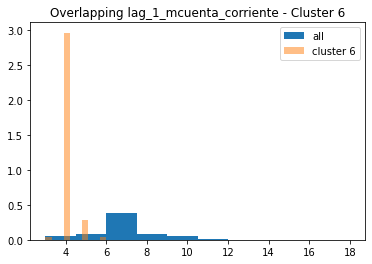

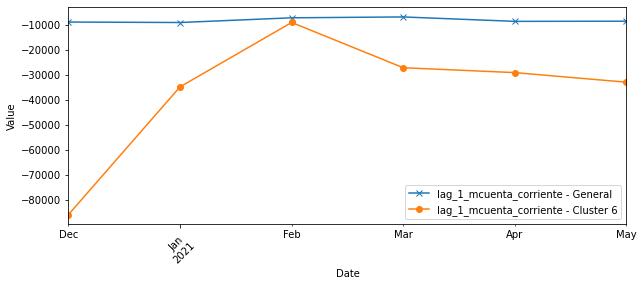

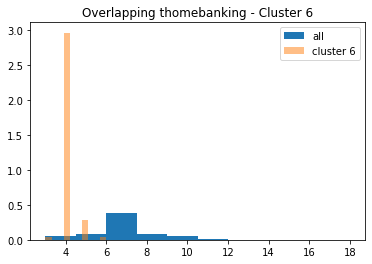

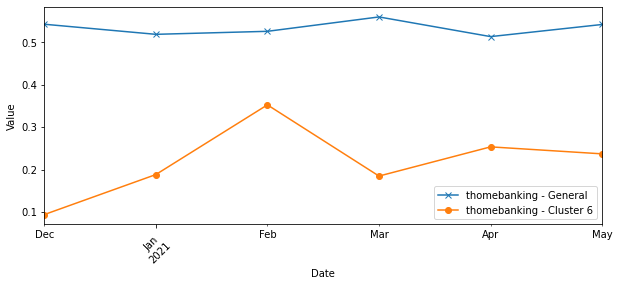

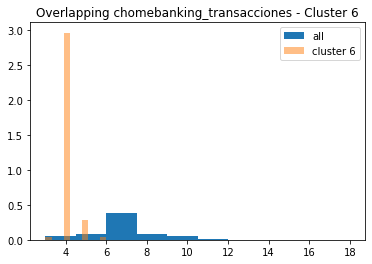

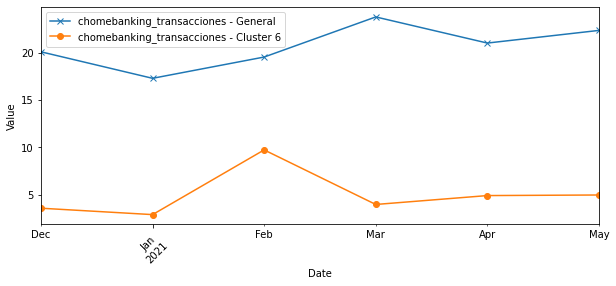

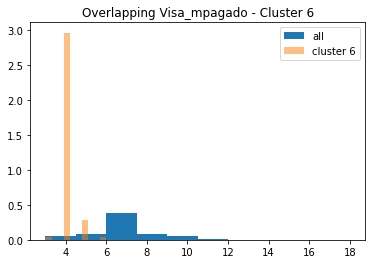

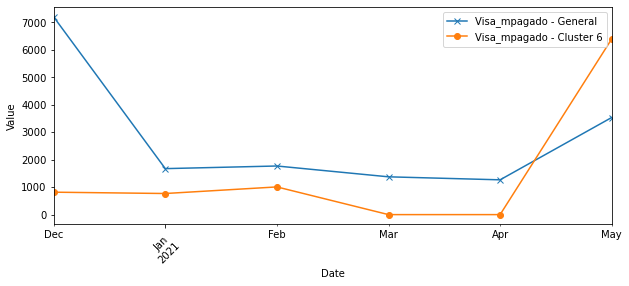

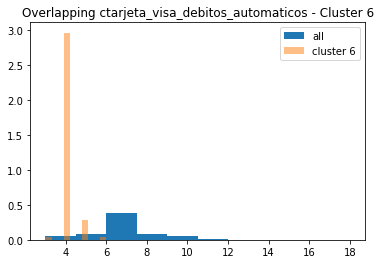

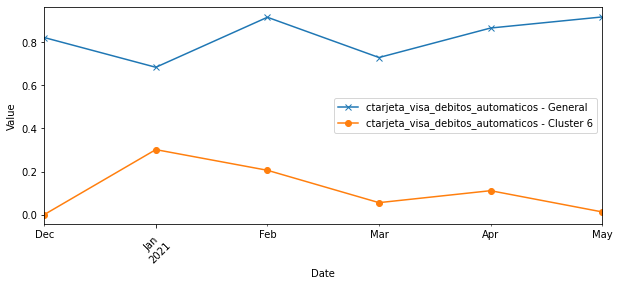

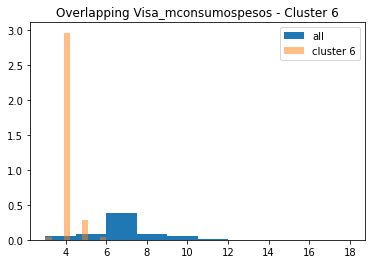

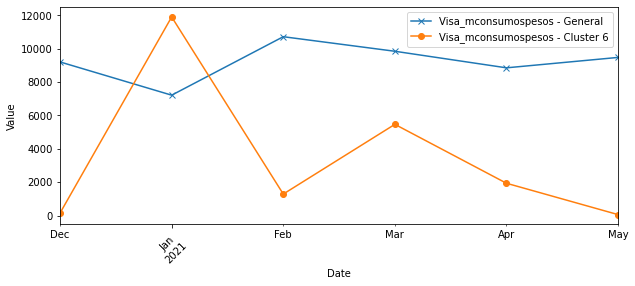

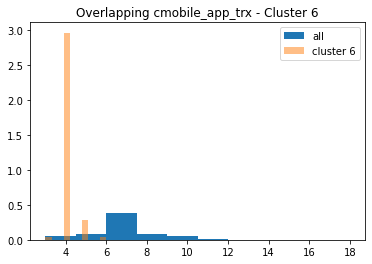

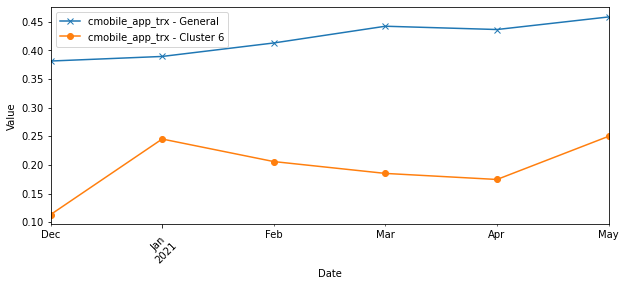

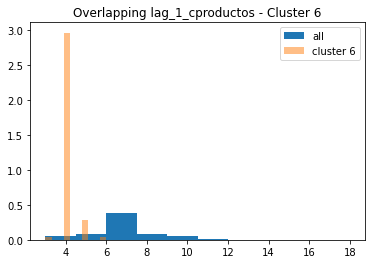

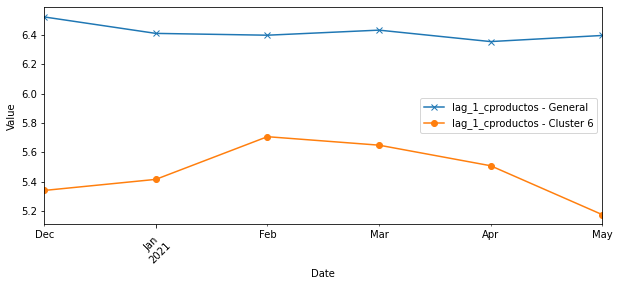

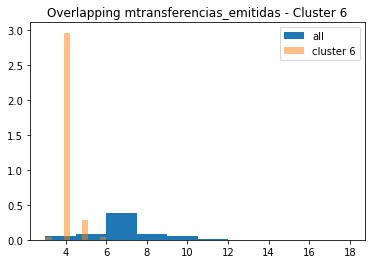

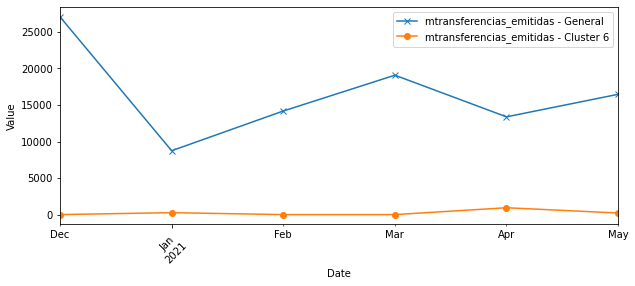

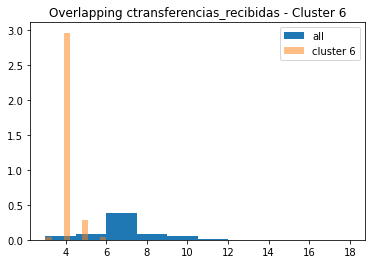

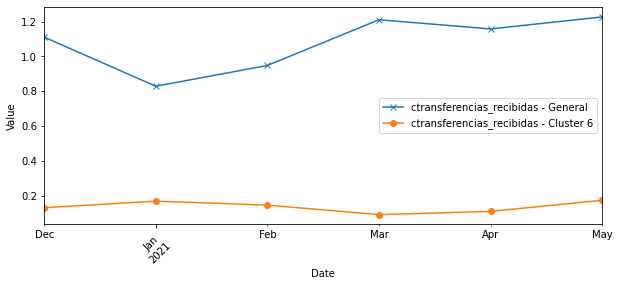

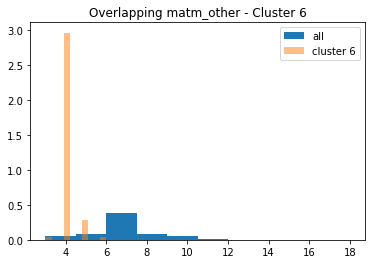

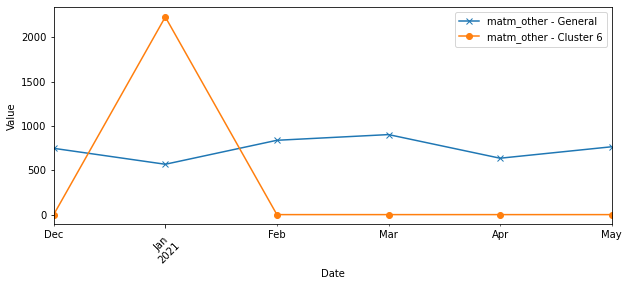

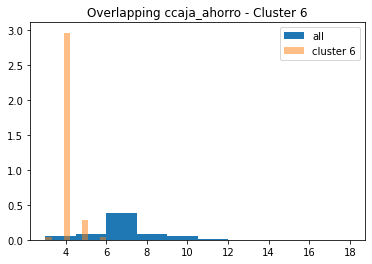

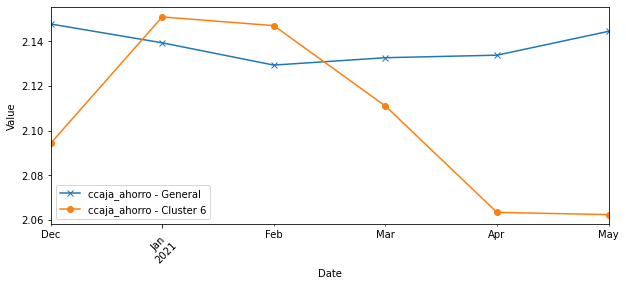


Shap importance for cluster 7:


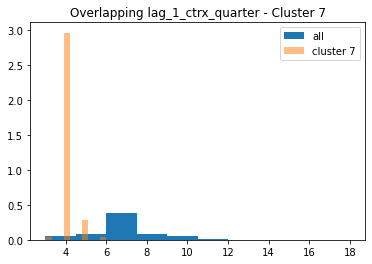

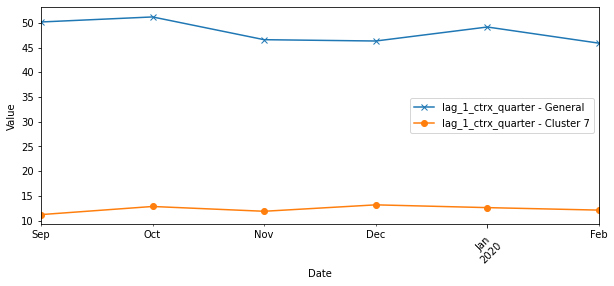

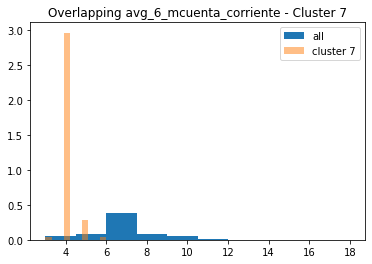

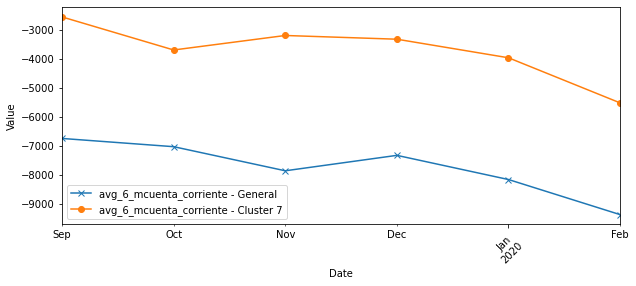

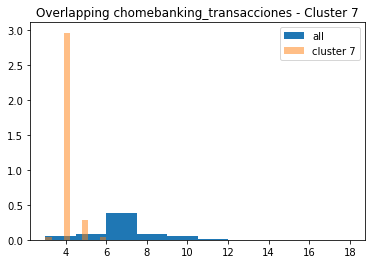

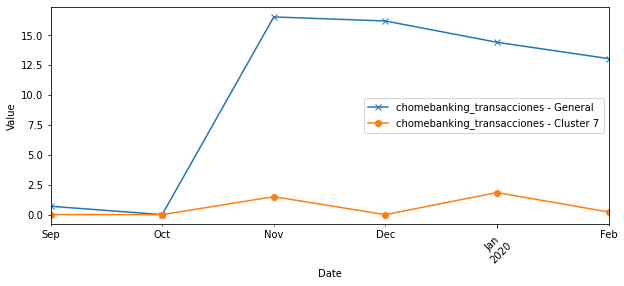

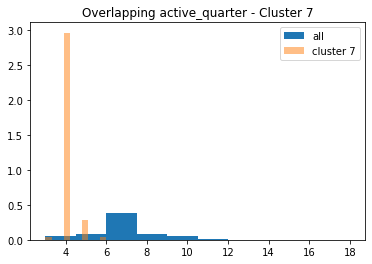

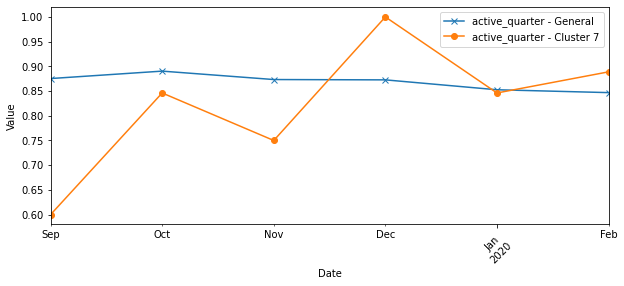

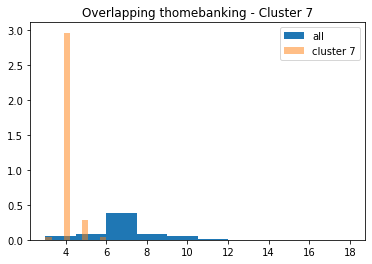

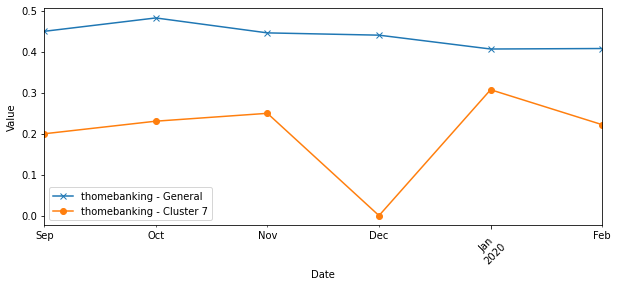

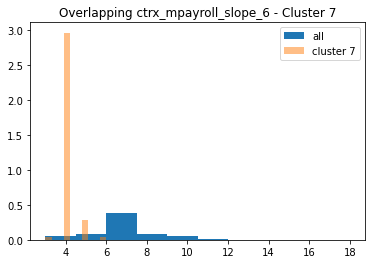

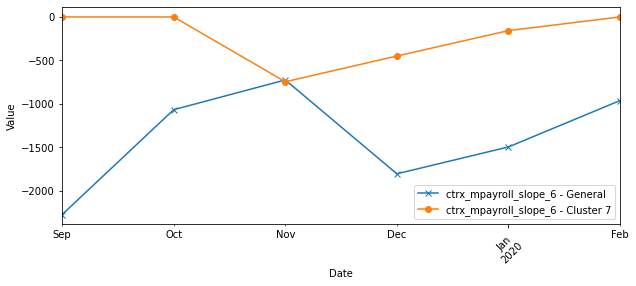

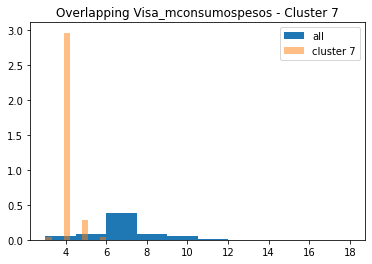

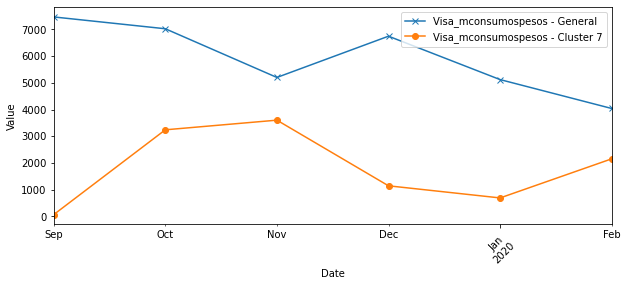

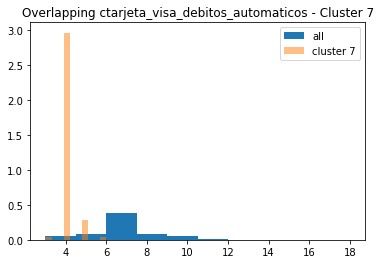

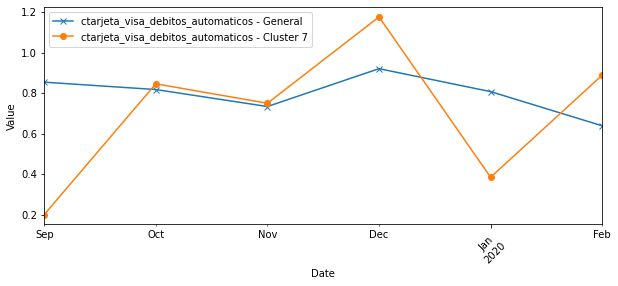

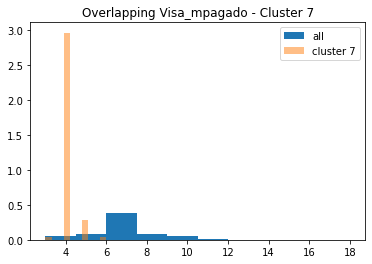

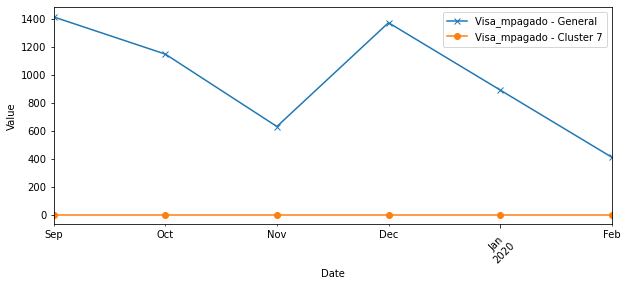

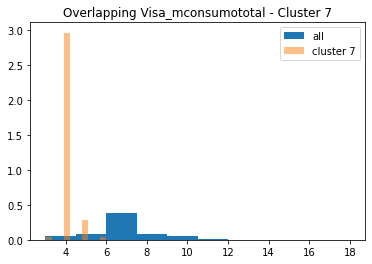

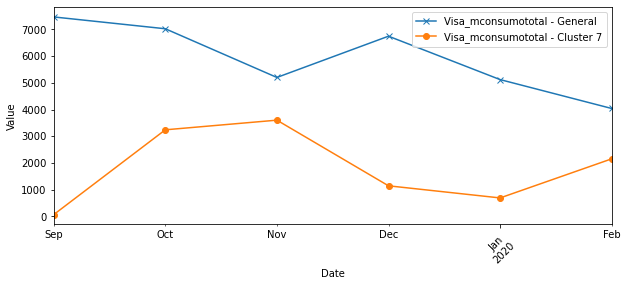

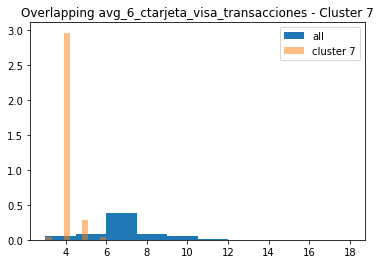

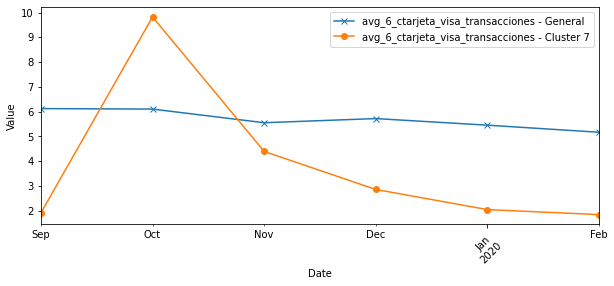

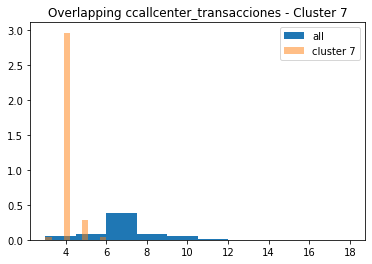

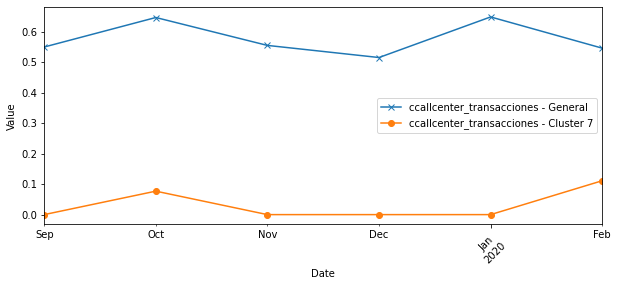

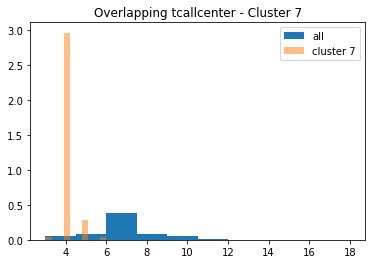

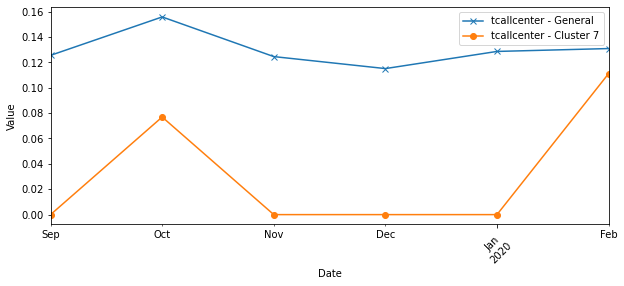

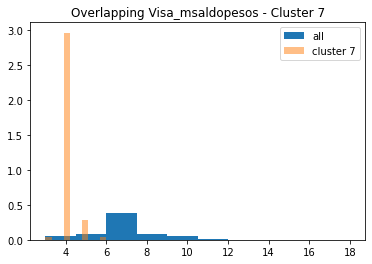

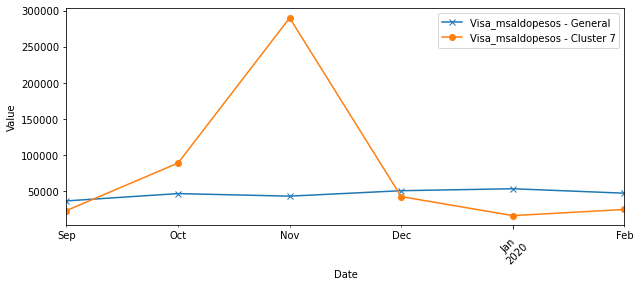

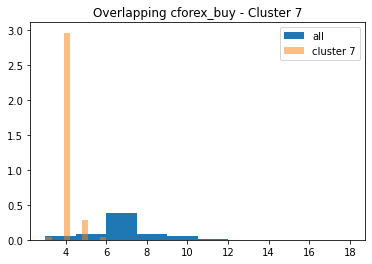

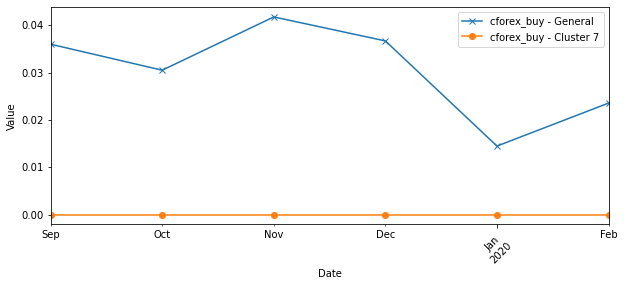


Shap importance for cluster 8:


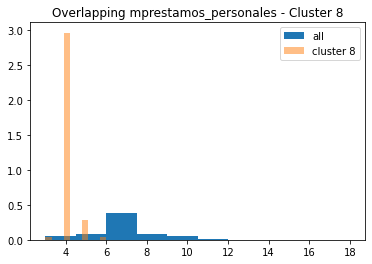

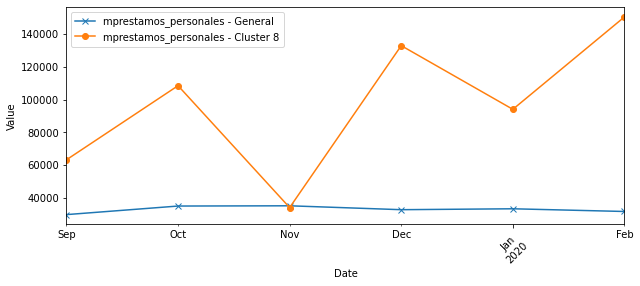

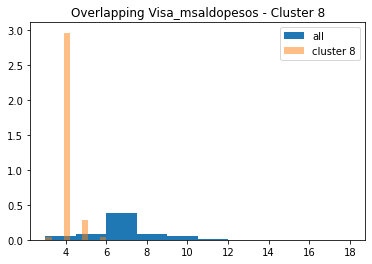

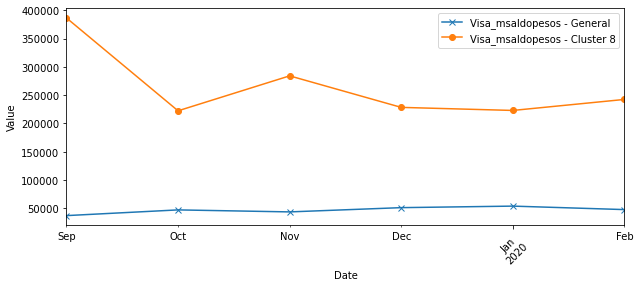

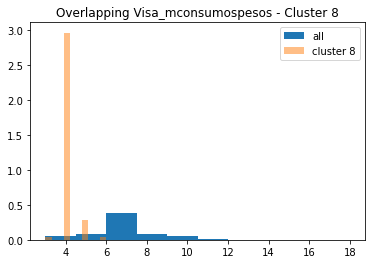

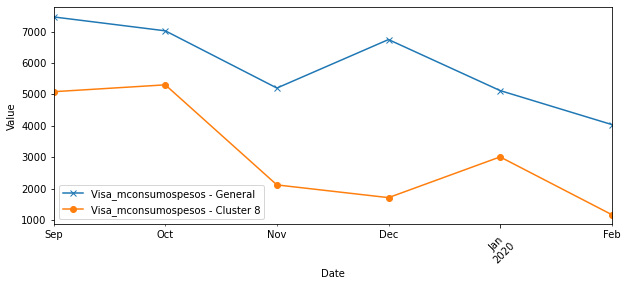

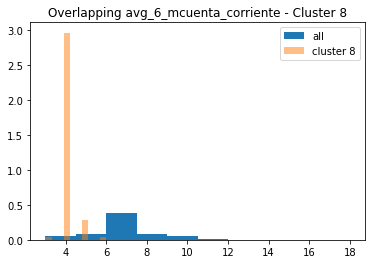

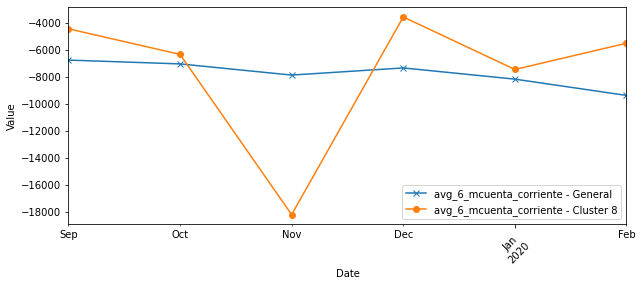

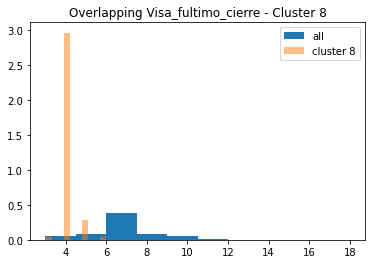

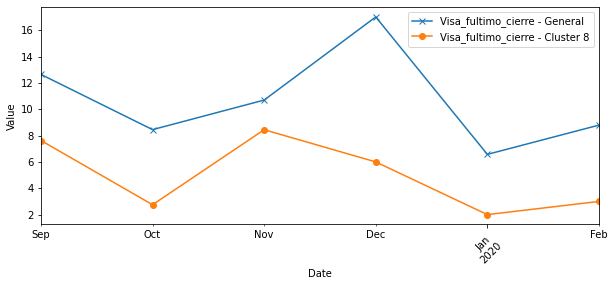

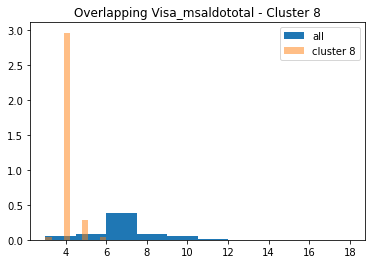

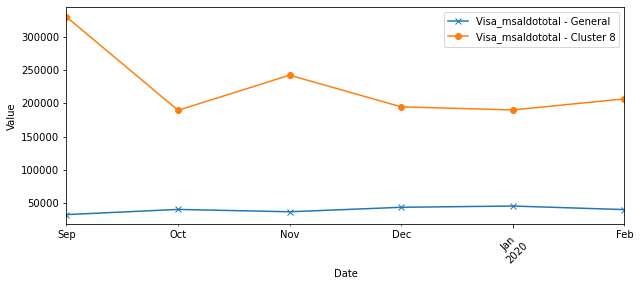

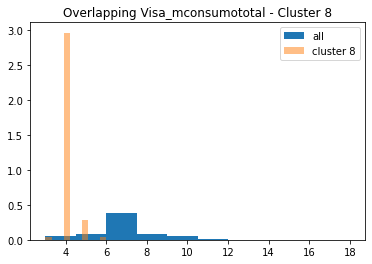

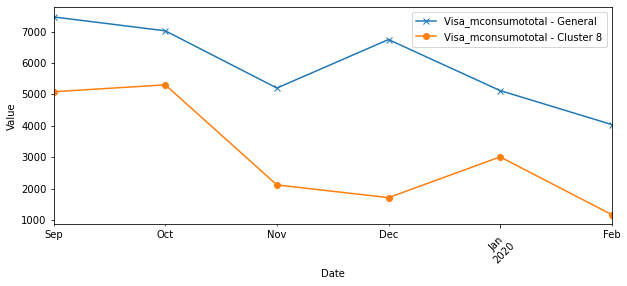

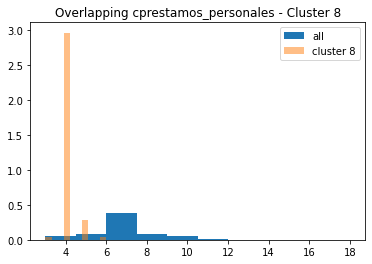

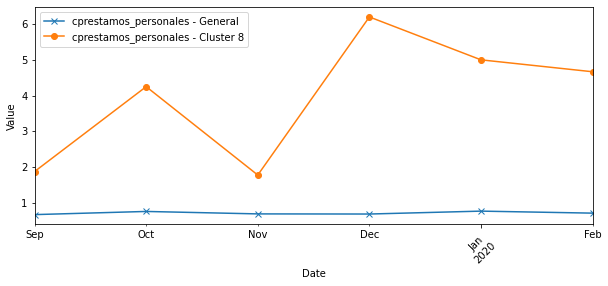

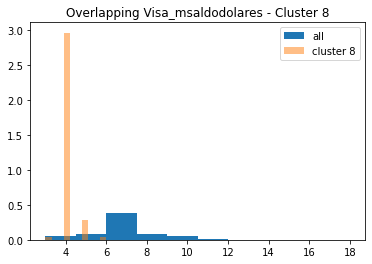

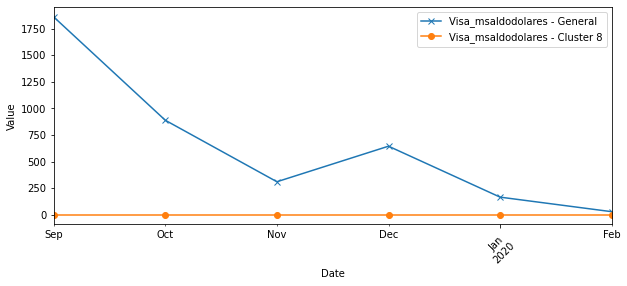

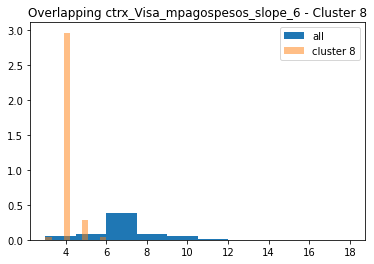

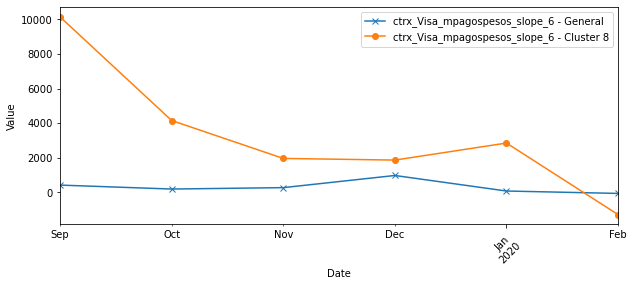

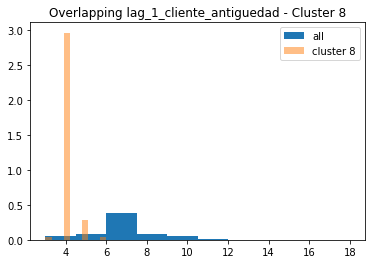

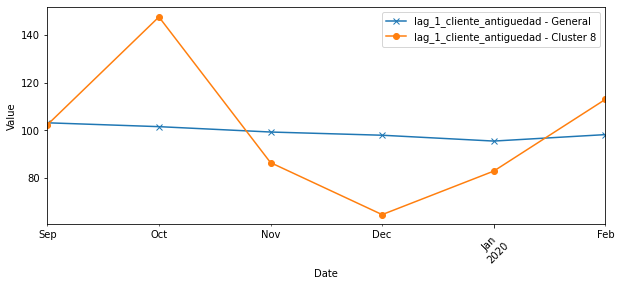

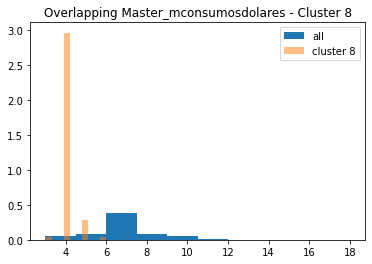

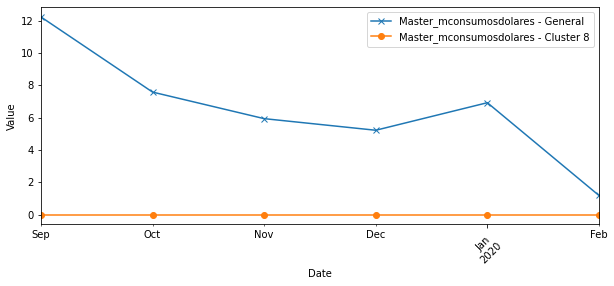

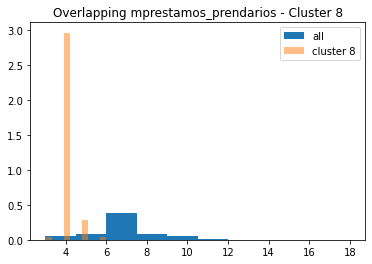

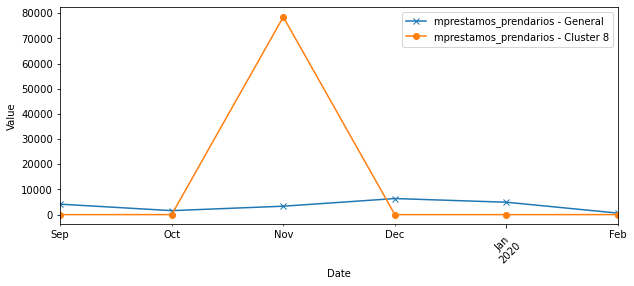

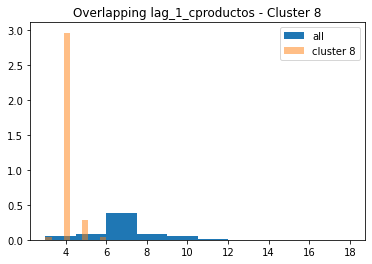

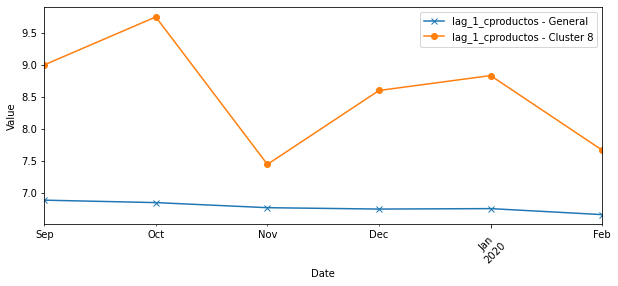

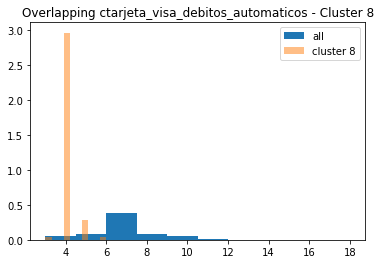

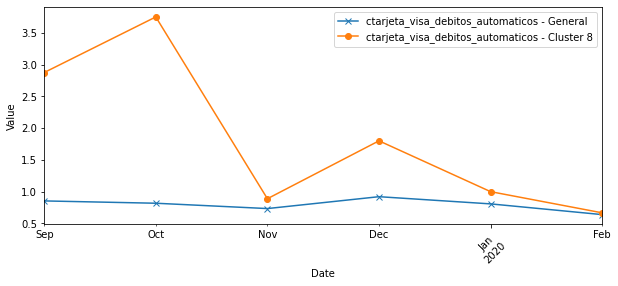


Shap importance for cluster 9:


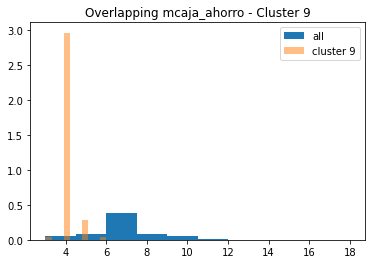

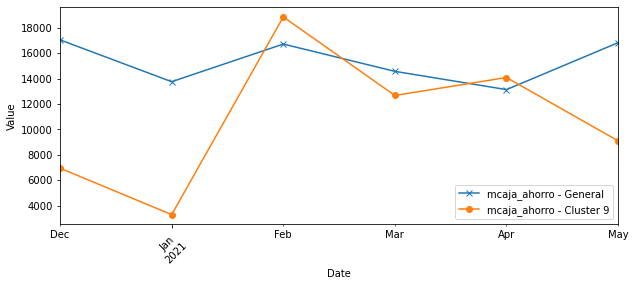

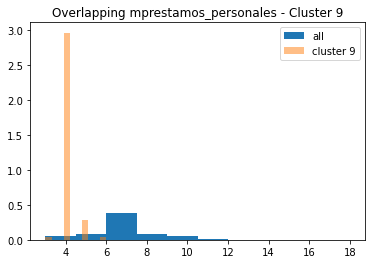

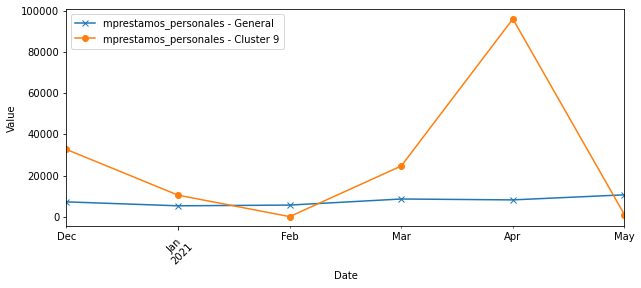

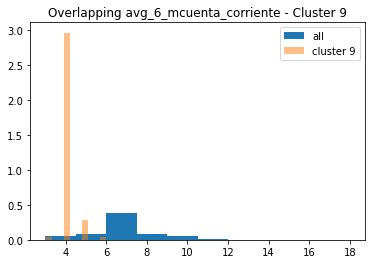

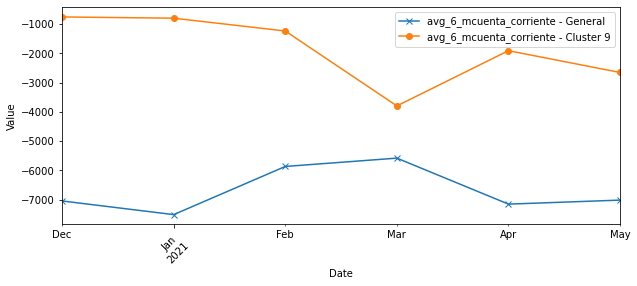

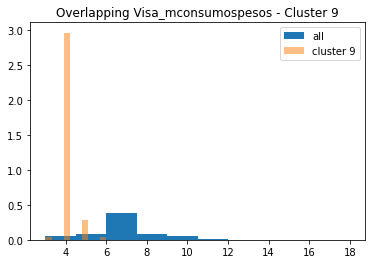

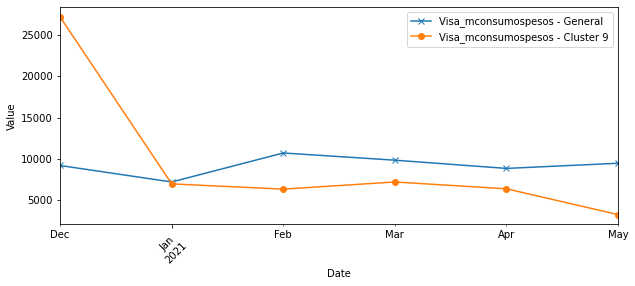

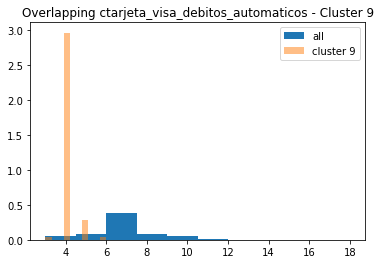

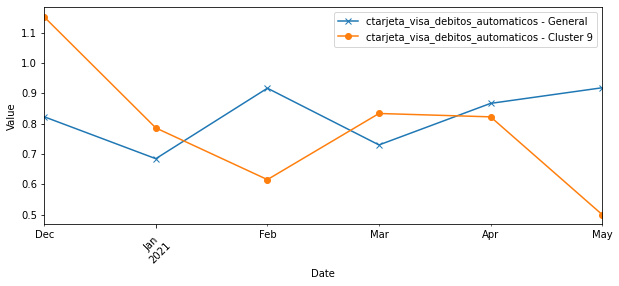

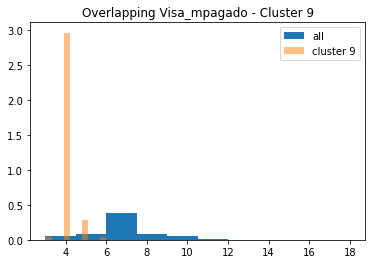

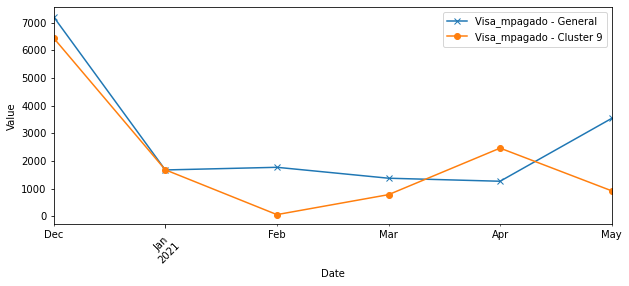

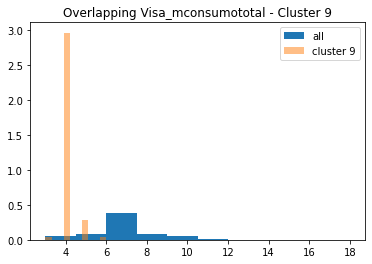

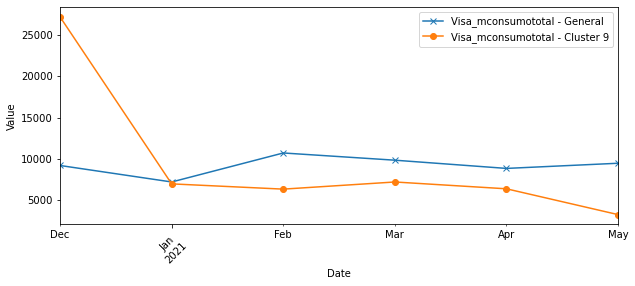

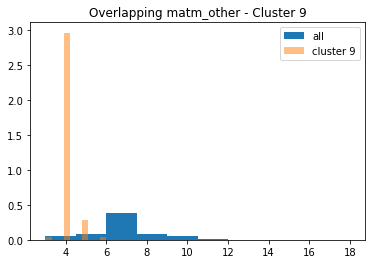

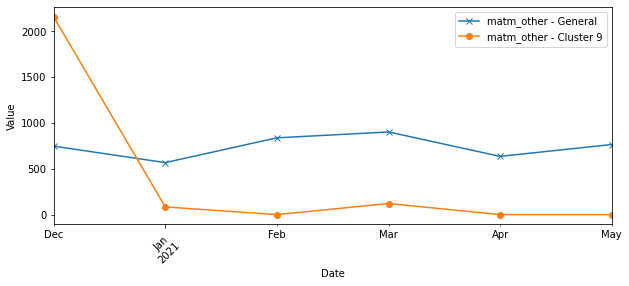

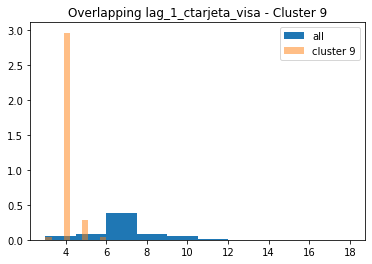

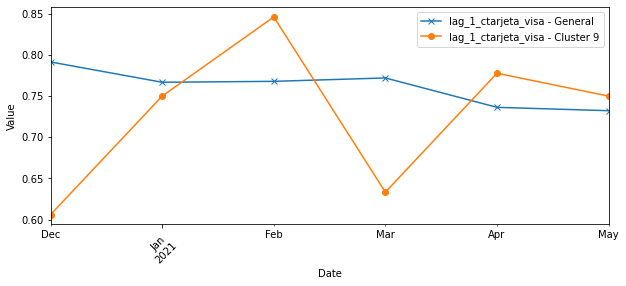

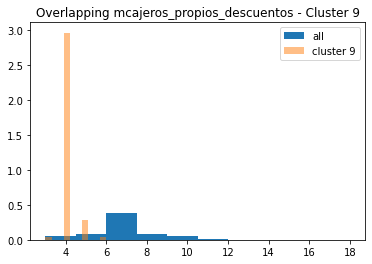

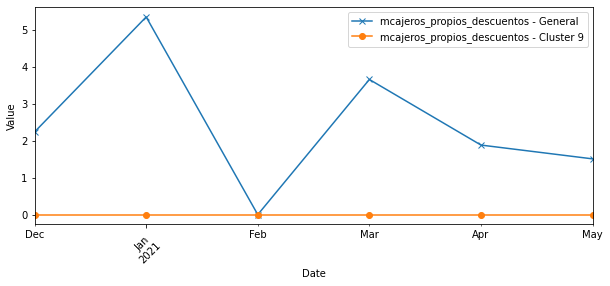

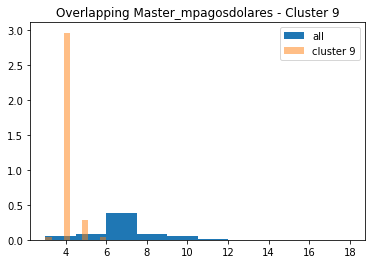

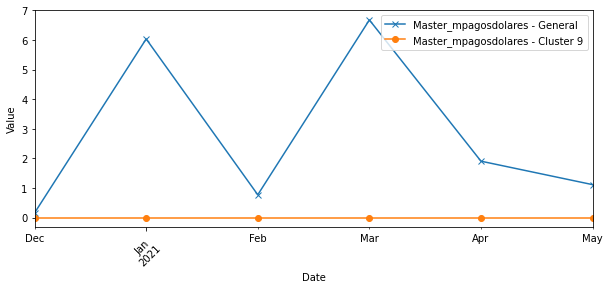

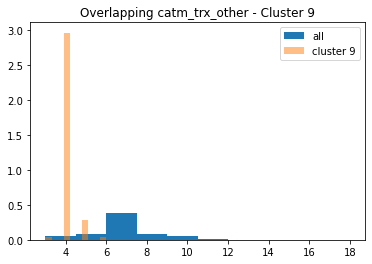

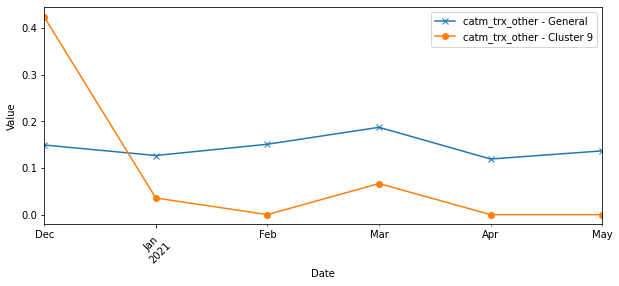

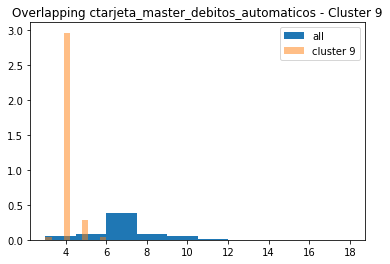

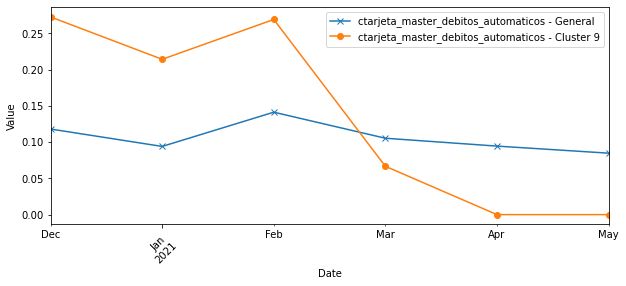

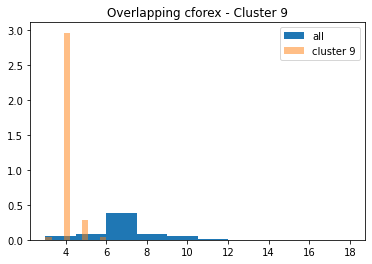

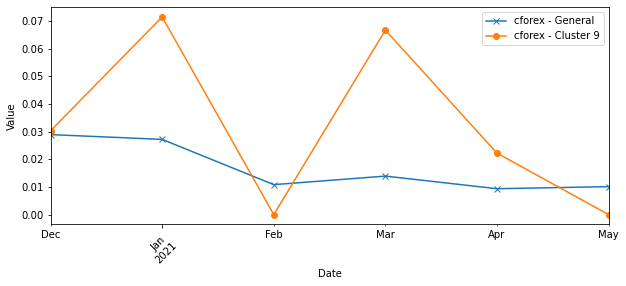

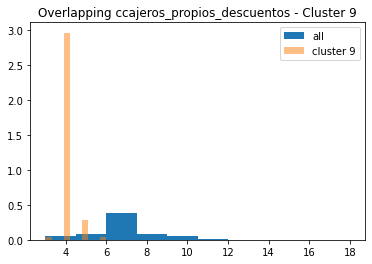

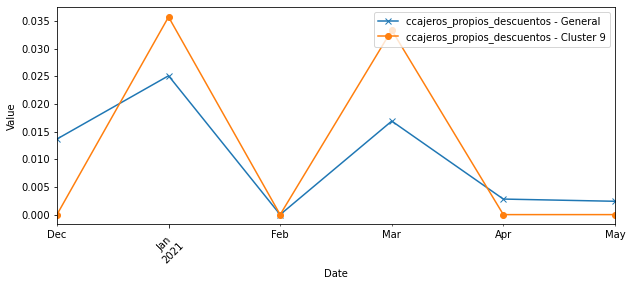


Shap importance for cluster 10:


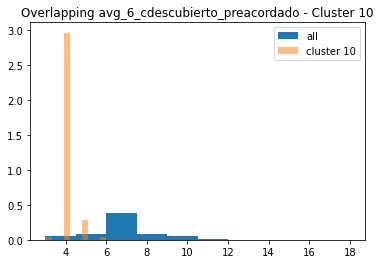

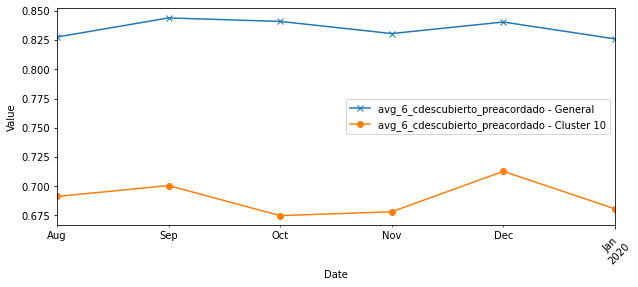

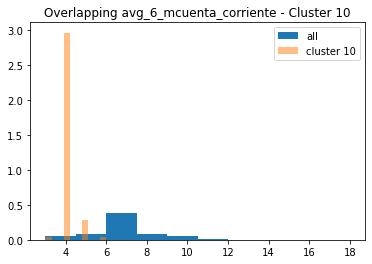

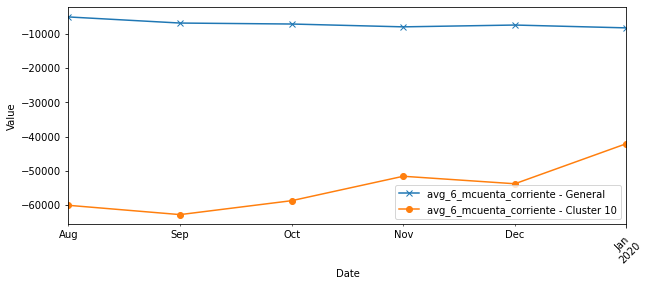

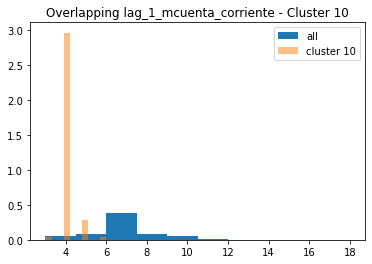

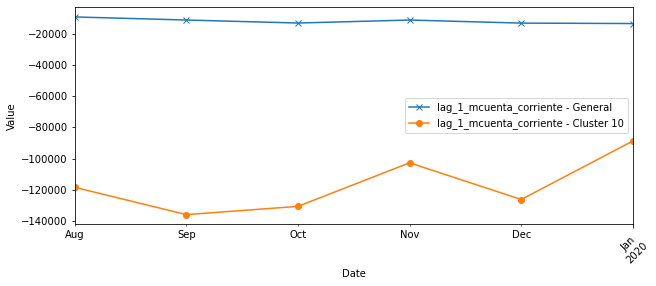

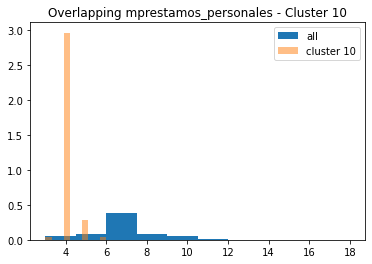

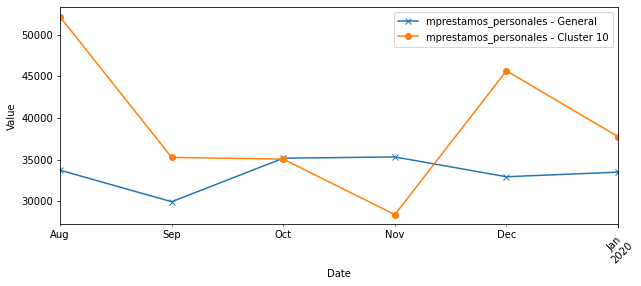

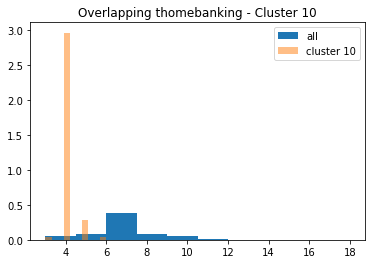

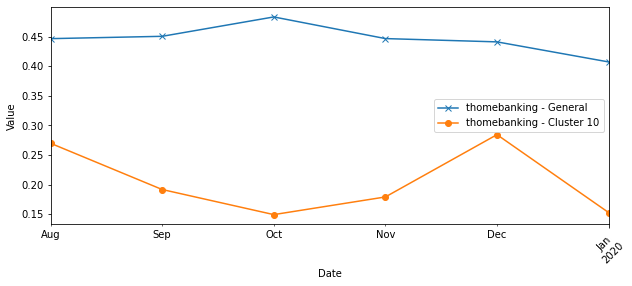

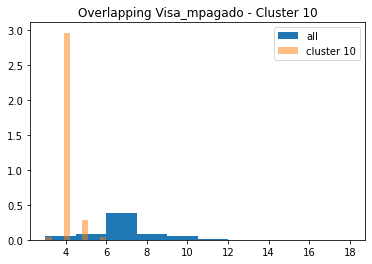

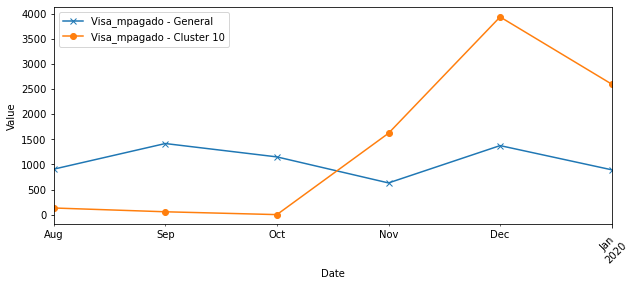

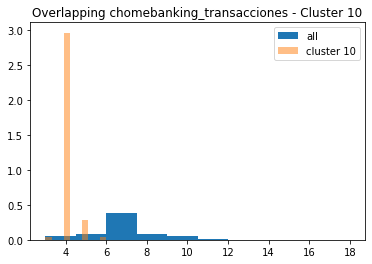

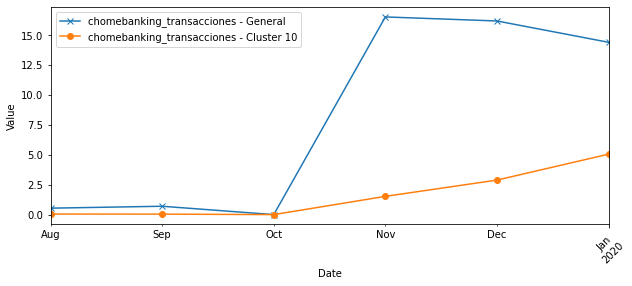

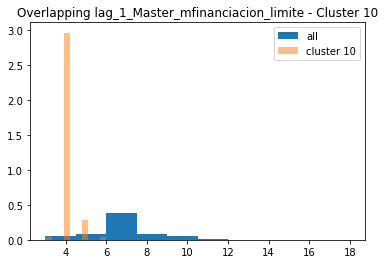

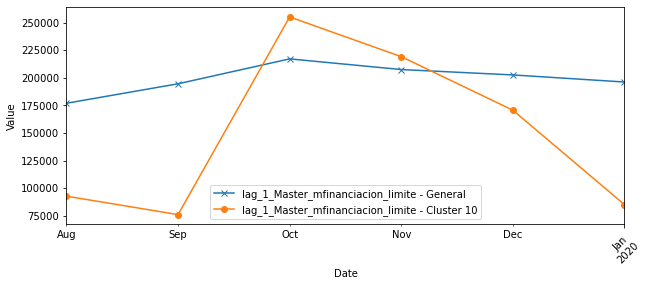

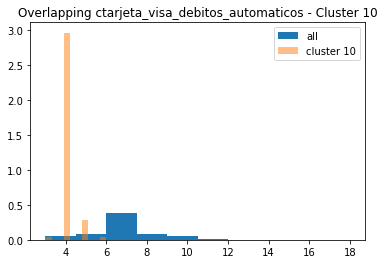

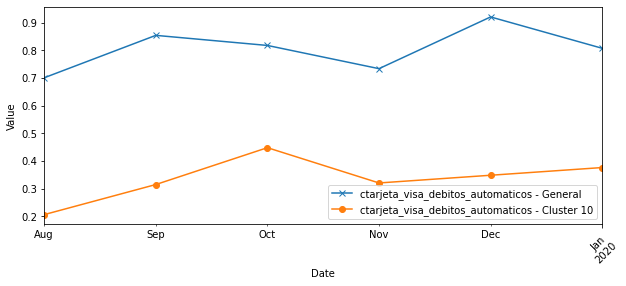

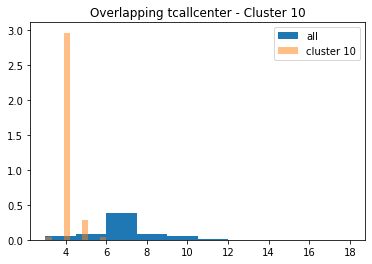

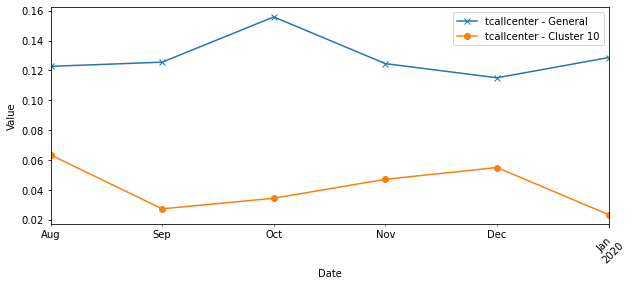

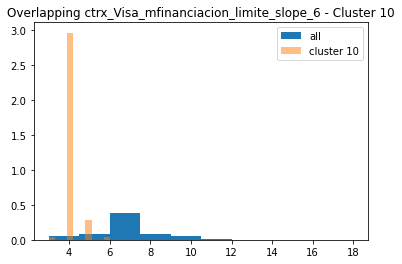

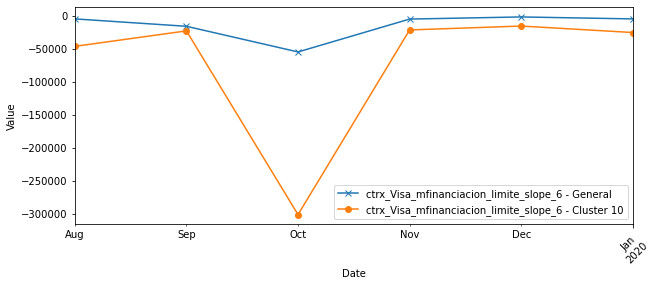

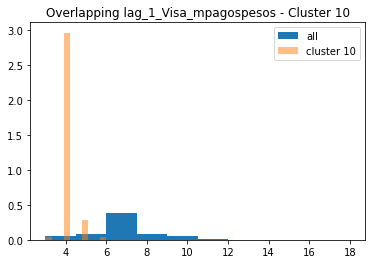

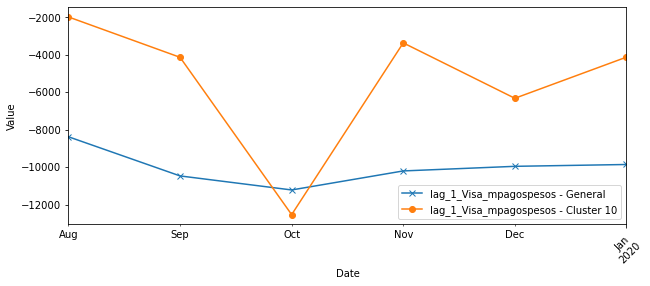

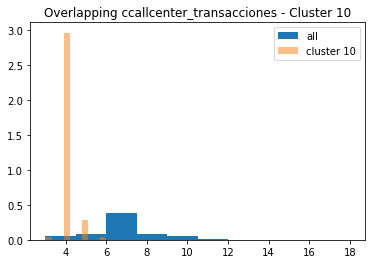

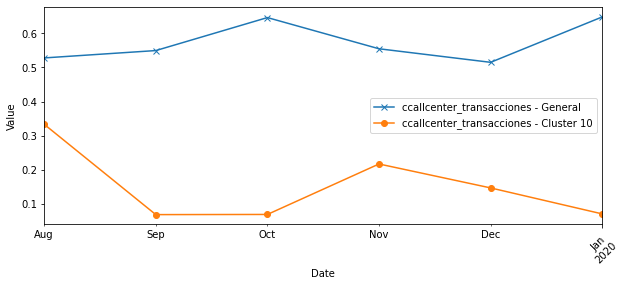

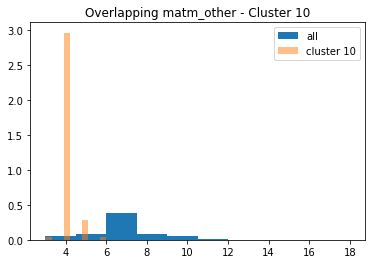

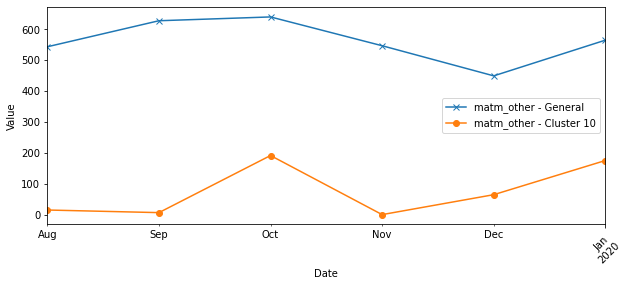

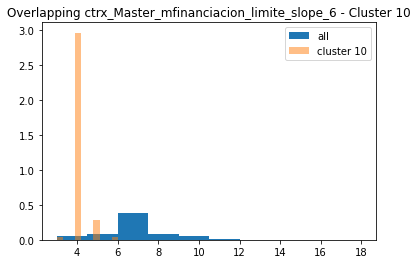

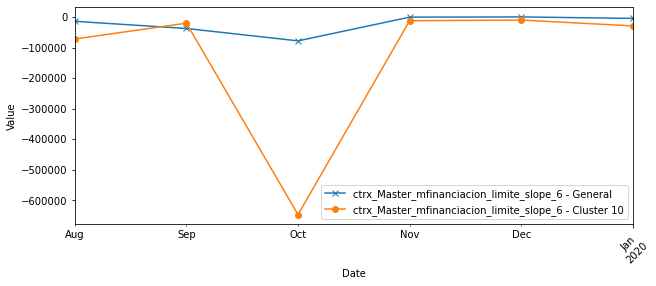


Shap importance for cluster 11:


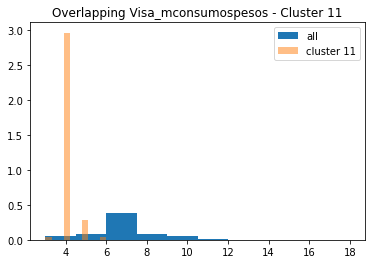

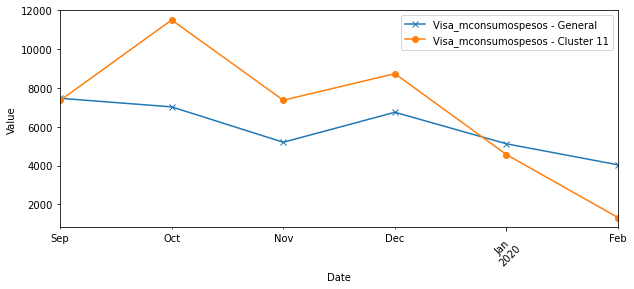

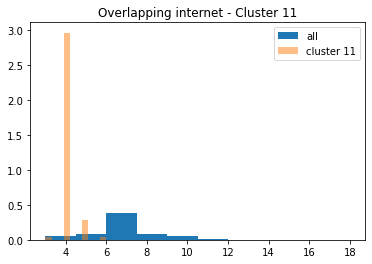

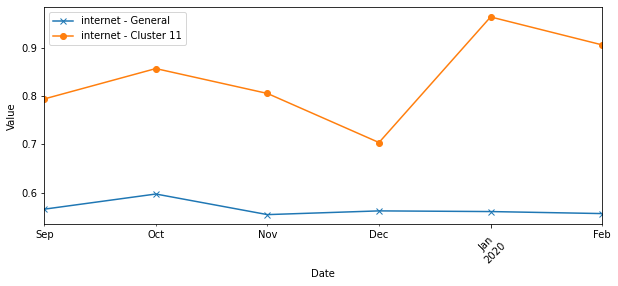

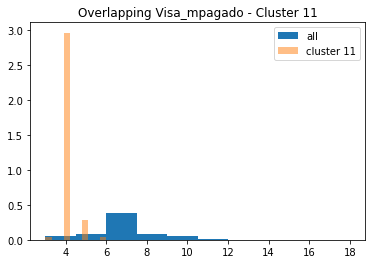

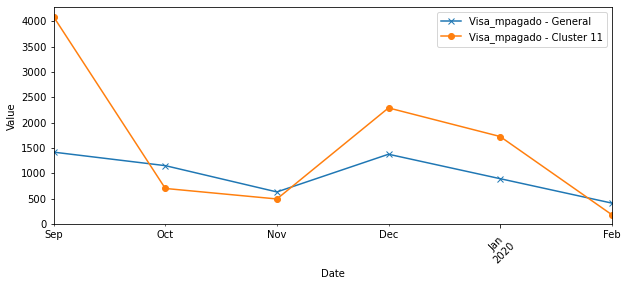

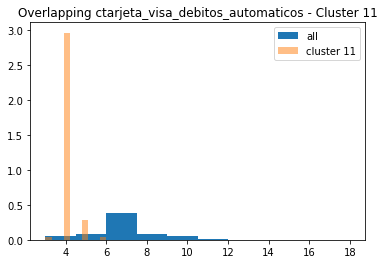

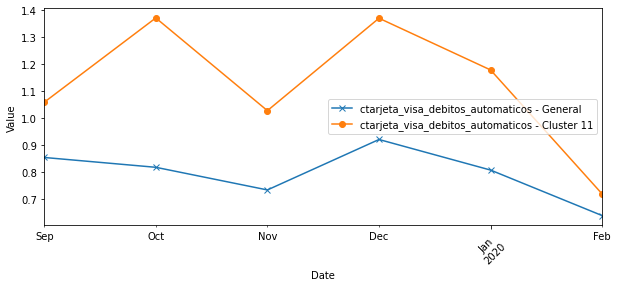

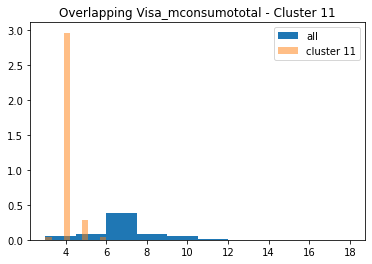

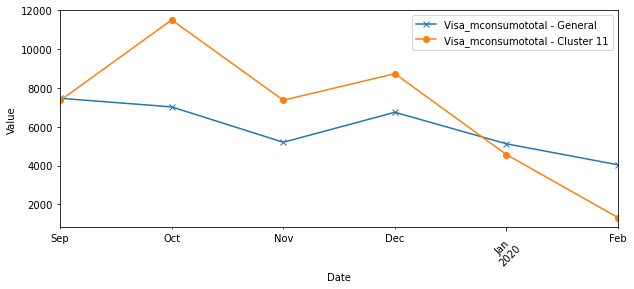

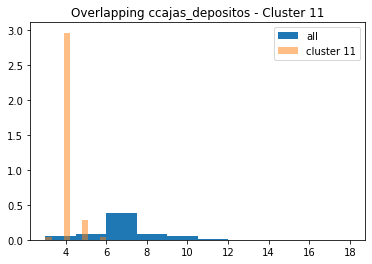

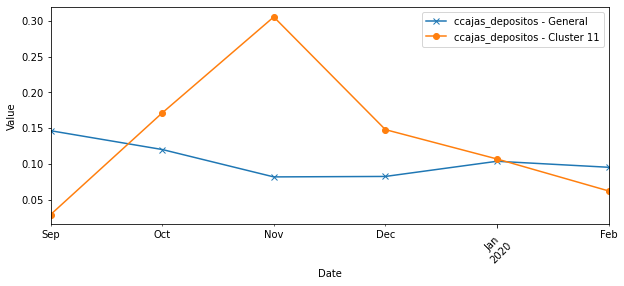

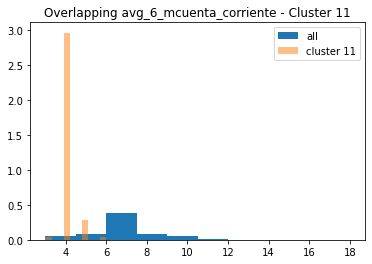

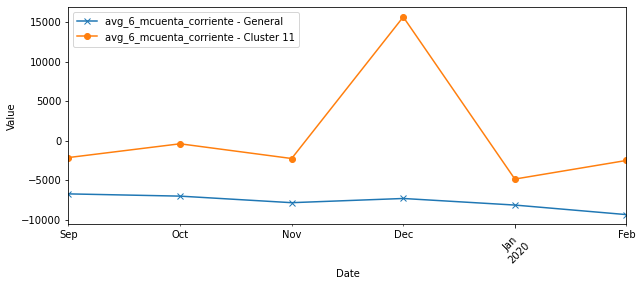

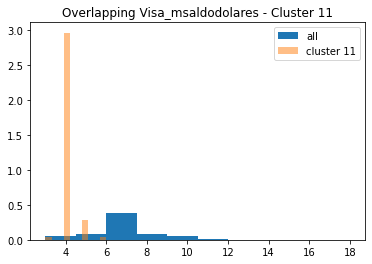

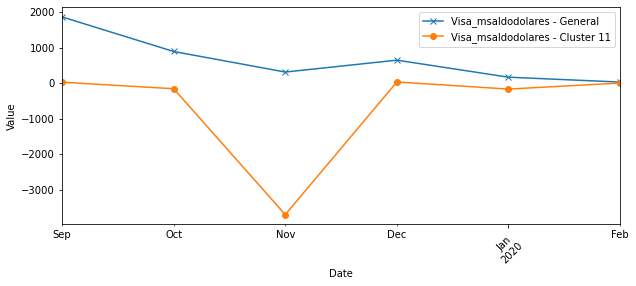

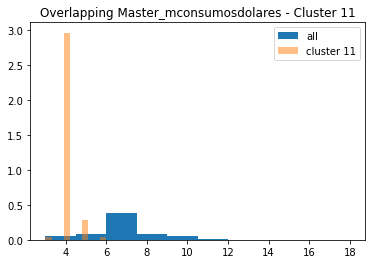

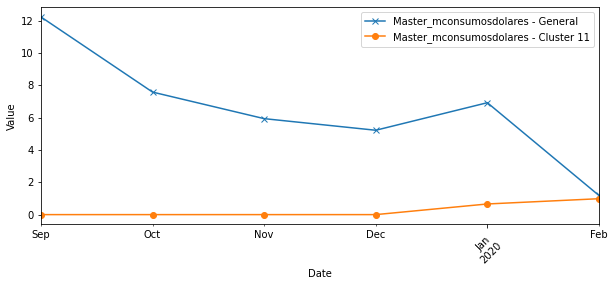

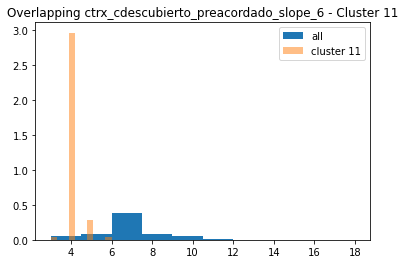

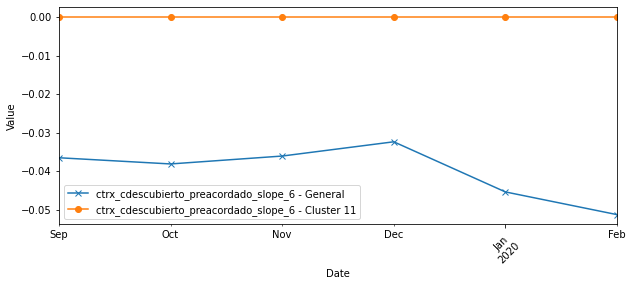

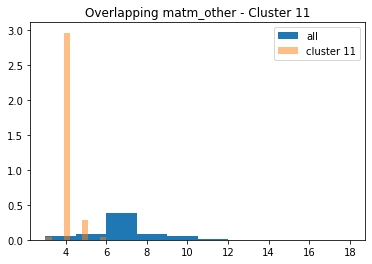

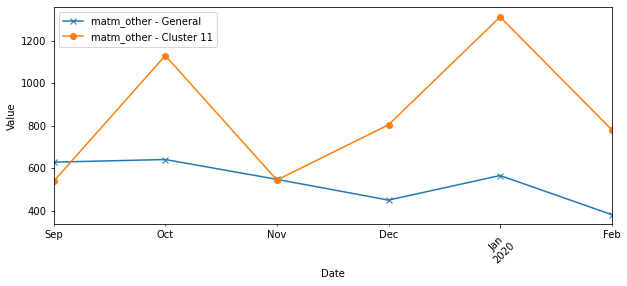

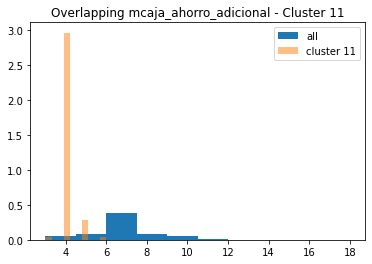

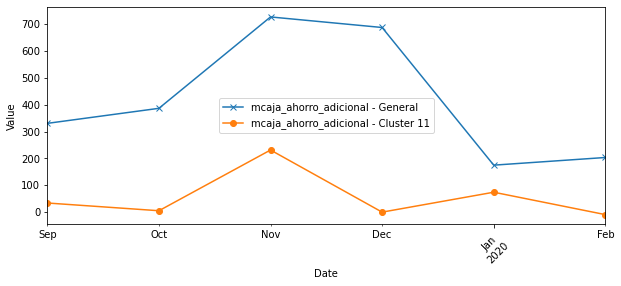

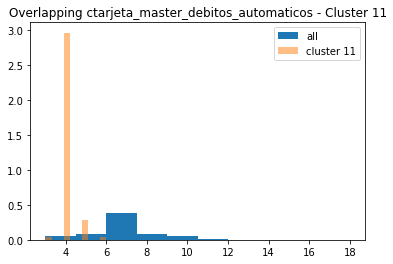

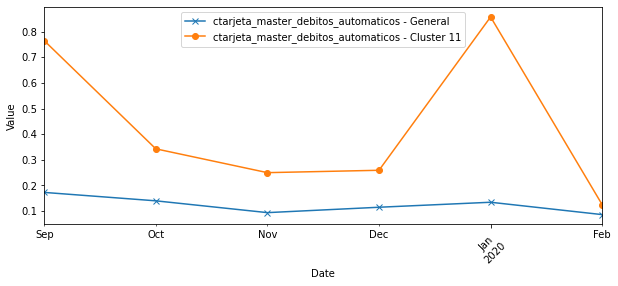

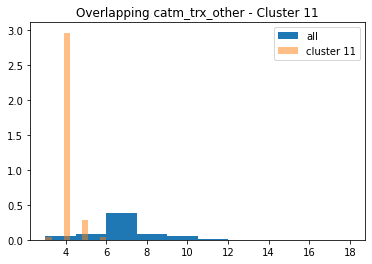

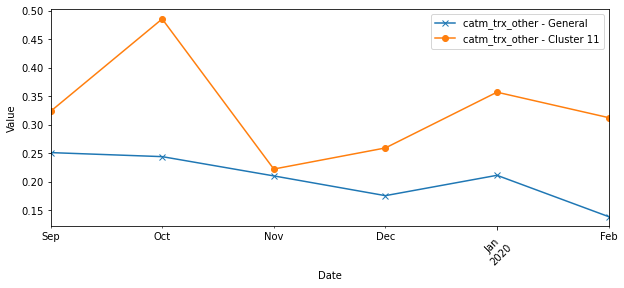

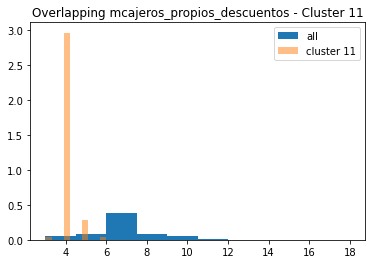

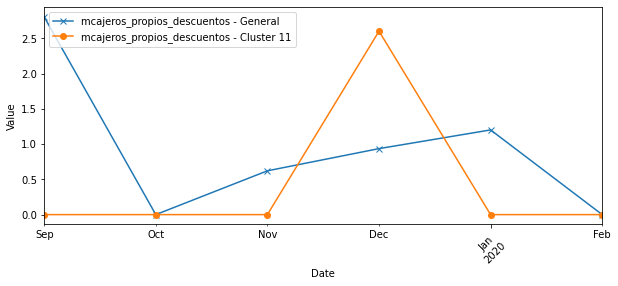


Shap importance for cluster 12:


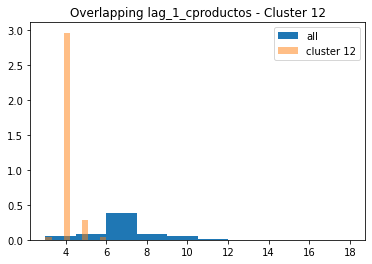

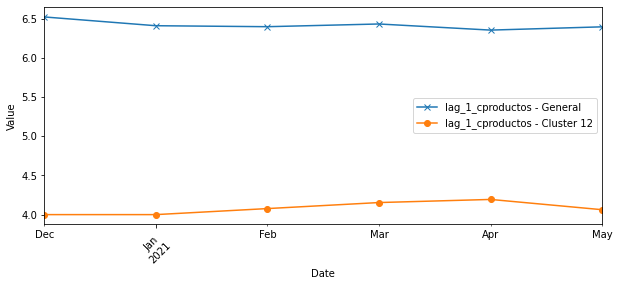

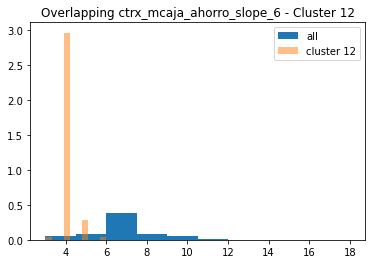

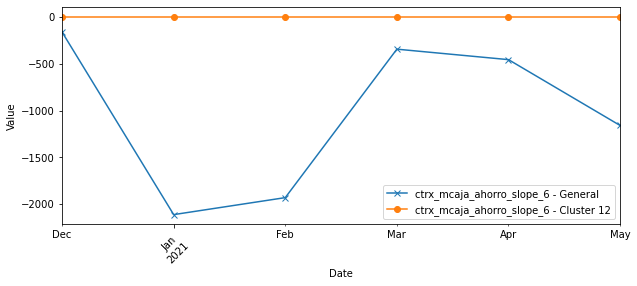

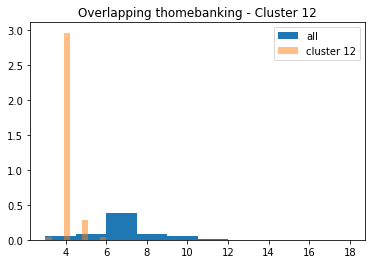

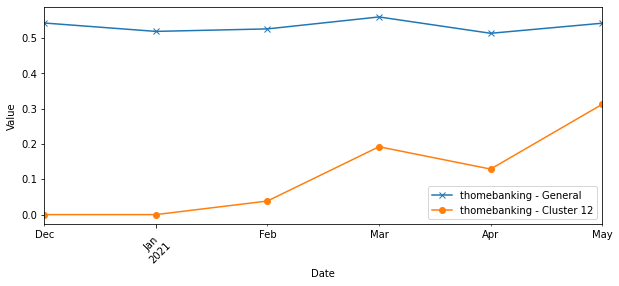

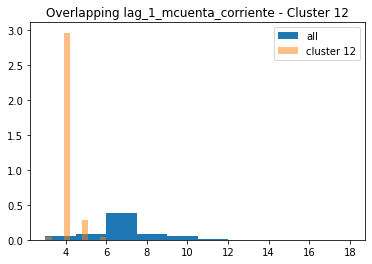

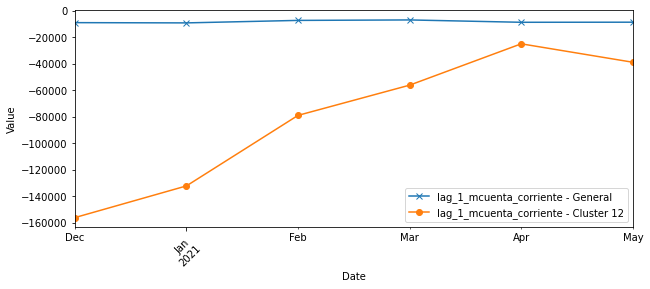

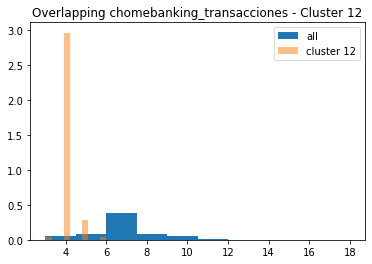

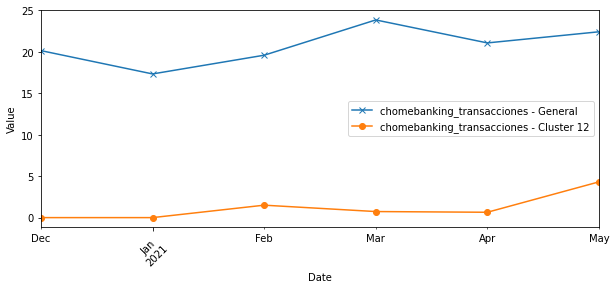

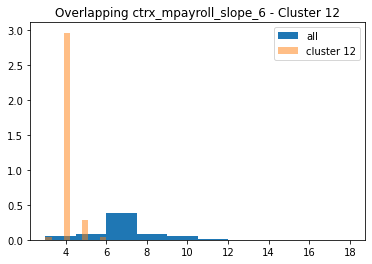

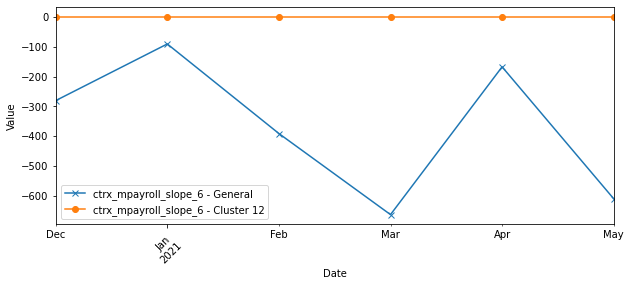

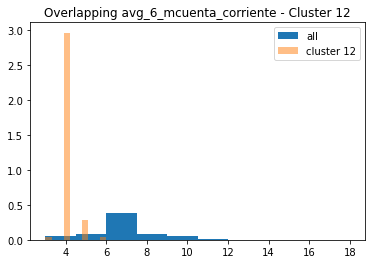

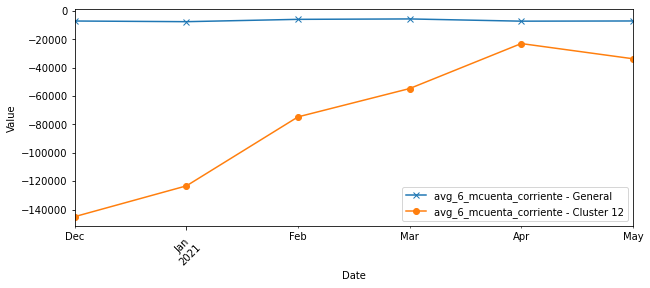

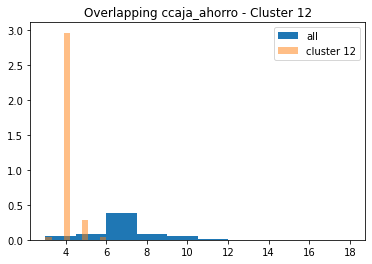

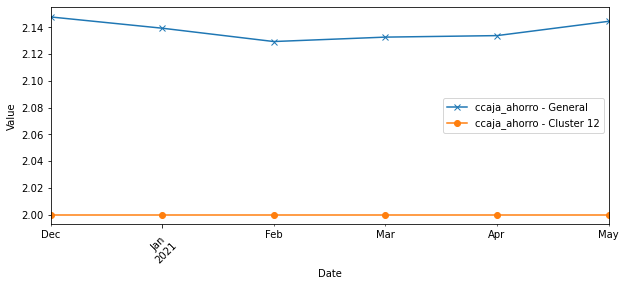

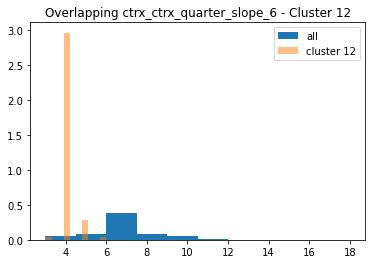

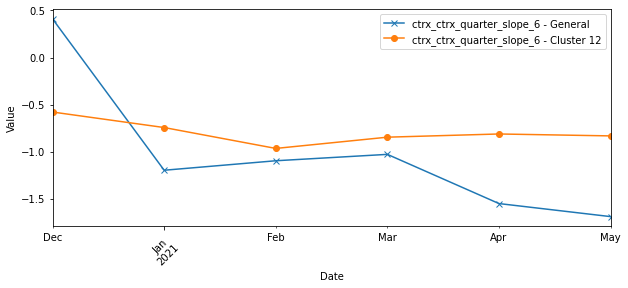

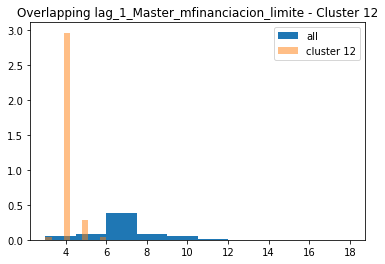

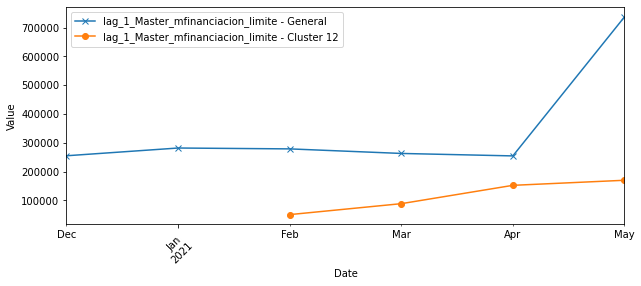

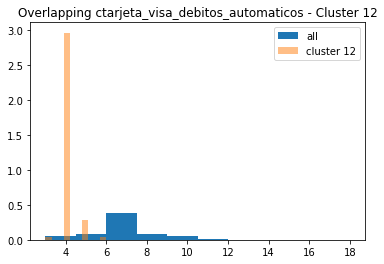

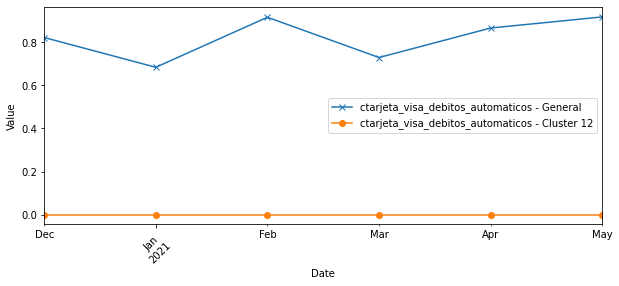

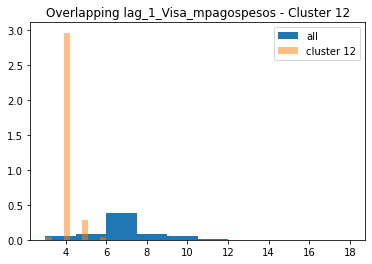

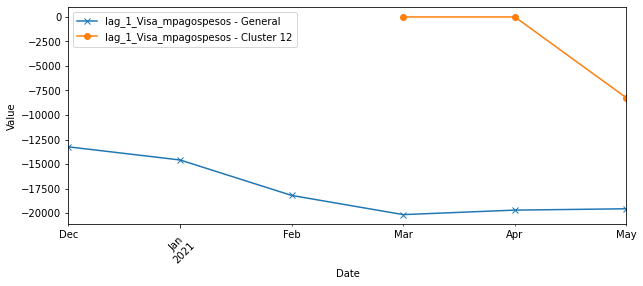

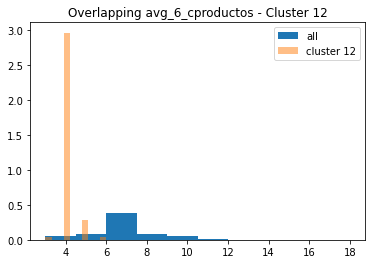

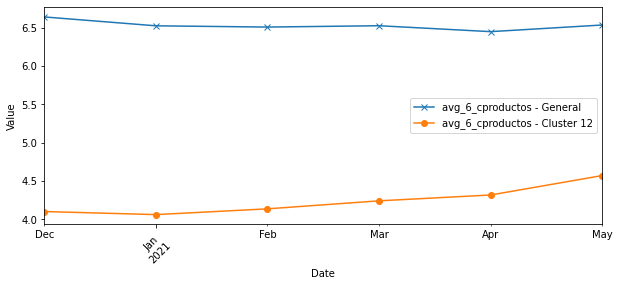

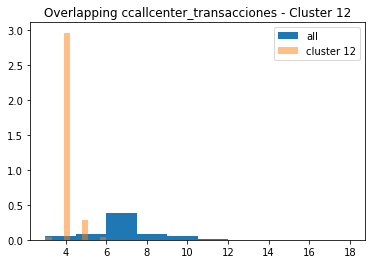

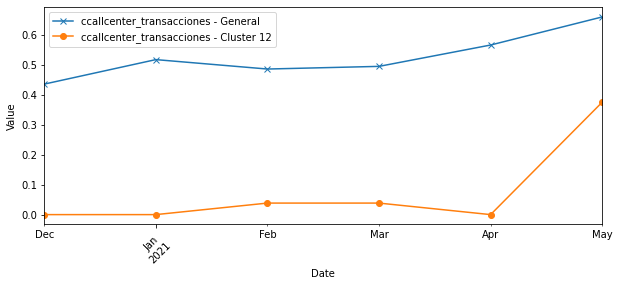

In [69]:
for i in range(0, len(clusters_list)-1):
    df_i = pd.DataFrame(shap_bajas[y.labels_ == i].mean().sort_values(ascending=False))
    df_i['variable'] = df_i.index
    print(f"\nShap importance for cluster {i}:")
    variables_i = df_i['variable'].to_list()
    
    # Crear un subconjunto de datos solo para el cluster actual
    cluster_data = ds_bajas[y.labels_ == i]
    
    for variable in variables_i[0:15]:
        if not cluster_data[variable].isna().all():
            # Histograma para el cluster actual
            plt.hist(all_values, label='all', density=True)
            plt.hist(cluster_values, label=f'cluster {i}', density=True, alpha=0.5)
    
            plt.legend(loc='upper right')
            plt.title(f'Overlapping {variable} - Cluster {i}')
            plt.show()
    
            # Crear un DataFrame con las variables seleccionadas y 'foto_mes' como índice para el cluster actual
            last_6_months = cluster_data['foto_mes'].sort_values().unique()[-6:]
            df_evolucion_cluster = cluster_data[cluster_data['foto_mes'].isin(last_6_months)][['foto_mes', variable]]
            df_evolucion_cluster['foto_mes'] = pd.to_datetime(df_evolucion_cluster['foto_mes'], format='%Y%m')
            
            # Agregar valores de 'variable' para los mismos períodos 'foto_mes'
            df_evolucion_cluster = df_evolucion_cluster.groupby('foto_mes')[variable].mean()
            
            # Crear un DataFrame con las variables seleccionadas y 'foto_mes' como índice para la población general
            df_evolucion_general = ds_bajas[ds_bajas['foto_mes'].isin(last_6_months)][['foto_mes', variable]]
            df_evolucion_general['foto_mes'] = pd.to_datetime(df_evolucion_general['foto_mes'], format='%Y%m')
            
            # Agregar valores de 'variable' para los mismos períodos 'foto_mes'
            df_evolucion_general = df_evolucion_general.groupby('foto_mes')[variable].mean()
    
            # Gráfico de evolución temporal comparativo
            plt.figure(figsize=(10, 4))
            df_evolucion_general.plot(label=f'{variable} - General', marker='x', legend=True)
            df_evolucion_cluster.plot(label=f'{variable} - Cluster {i}', marker='o', legend=True)
            
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.xticks(rotation=45)
            plt.show()

In [62]:
ds_bajas.dtypes

foto_mes                               int64
active_quarter                         int64
cliente_vip                            int64
internet                               int64
cliente_edad                           int64
                                      ...   
avg_6_Visa_mpagospesos               float64
avg_6_mrentabilidad_annual           float64
avg_6_cproductos                     float64
avg_6_Master_mfinanciacion_limite    float64
avg_6_Visa_mfinanciacion_limite      float64
Length: 204, dtype: object

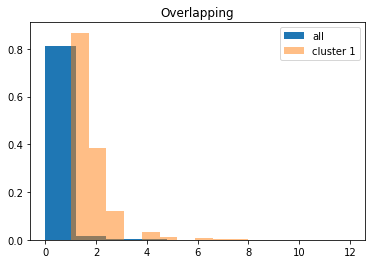

In [41]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True)
plt.hist(ds_bajas.loc[y.labels_ == 1]["cpayroll_trx"], label=f'cluster 1', density=True, alpha =0.5)

plt.legend(loc='upper right')
plt.title(f'Overlapping')
plt.show()
        

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

Analizamos cada uno de los clusters

In [29]:
df_0

NameError: name 'df_0' is not defined

In [40]:
for variable in df_1[:
    plt.hist(df["cpayroll_trx"], label='all', density=True, bins=25)
    for cluster_label in df['y.labels_'].unique():
        plt.hist(df[df['y.labels_'] == cluster_label]["cpayroll_trx"], label=f'cluster {cluster_label}', density=True, bins=25)
    
    plt.legend(loc='upper right')
    plt.title(f'Distribución de {variable} en Clusters y Población')
    plt.show()

SyntaxError: '[' was never closed (3125556545.py, line 1)

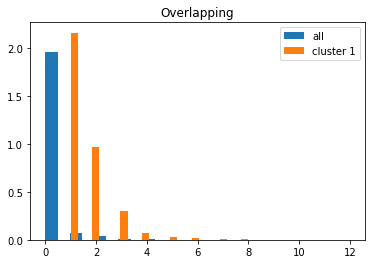

In [17]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 1]["cpayroll_trx"], label='cluster 1', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

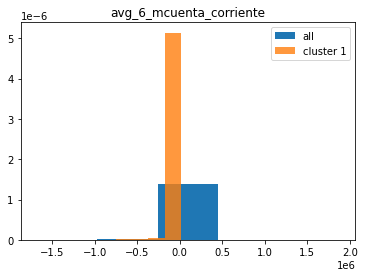

In [30]:
plt.hist(ds_bajas.loc[:]["avg_6_mcuenta_corriente"], label='all', density=True, bins=5)
plt.hist(ds_bajas.loc[y.labels_ == 5]["avg_6_mcuenta_corriente"], label='cluster 1', density=True, bins=5, alpha=0.8)

plt.legend(loc='upper right')
plt.title('avg_6_mcuenta_corriente')
plt.show()

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [18]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].sample(2000).index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [19]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [20]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

using precomputed metric; inverse_transform will be unavailable


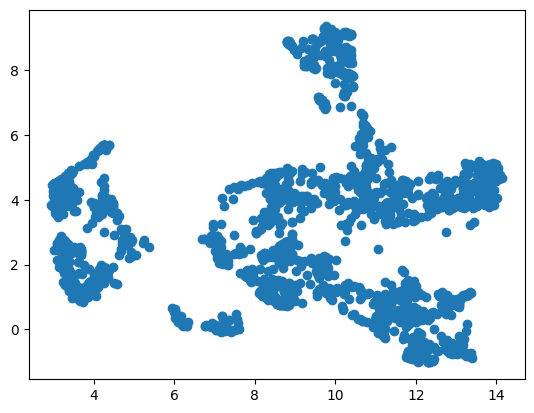

In [21]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])